# Mactop Analyse

In [4]:
import os
import numpy as np
import pandas as pd
import cooler
from sklearn import metrics
from sklearn.decomposition import PCA
import math
import sklearn.metrics as lunkuo
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pyBigWig as BW
from scipy.stats import stats
import networkx as nx
import powerlaw
from collections import Counter
import markov_clustering as mc
from scipy.signal import savgol_filter
from scipy.sparse import coo_matrix
from matplotlib.colors import LinearSegmentedColormap
import re

## Analyse Functions

In [5]:
def mctad_result_format(result_path, threshold):
    result_list = []
    for index in range(1, 24):
        hold_list = []
        filepath = "{0}/chr{1}_min_score_1.7.txt".format(result_path, index)
        valuepath = "{0}/chr{1}_min_value_1.7.txt".format(result_path, index)
        reloca = np.loadtxt(filepath, dtype=np.int)
        rescore = np.loadtxt(valuepath)
        for index in range(len(rescore)):
            if rescore[index] < threshold:
                hold_list.append(reloca[index])
        result_list.append(hold_list)

    return result_list

def mctad_result_format2(result_path, threshold):
    result_list = []
    for index in range(1, 24):
        hold_list = []
        filepath = "{0}/chr{1}_min_score.txt".format(result_path, index)
        valuepath = "{0}/chr{1}_min_value.txt".format(result_path, index)
        reloca = np.loadtxt(filepath, dtype=np.int)
        rescore = np.loadtxt(valuepath)
        for index in range(len(rescore)):
            if rescore[index] < threshold:
                hold_list.append(reloca[index])
        result_list.append(hold_list)

    return result_list

def topdom_result_format(result_path,celline):
    result_list = []
    for index in range(1,24):
        filepath = "{0}/{1}_MboI_chr{2}_topdomResult.domain".format(result_path, celline, index)
        data = pd.read_csv(filepath, sep='\t')
        topre = np.array(data['from.id'])
        result_list.append(topre)
    return result_list

def di_result_format(result_path,celline):
    result_list = []
    for index in range(1,24):
        filepath = "{0}/{1}_50kb_chr{2}finaldomaincalls".format(result_path, celline, index)
        data = pd.read_csv(filepath, header=None, sep='\t')
        re = data.loc[:,1]/50000
        re = np.array(re, dtype=np.int32).tolist()
        result_list.append(re)
    return result_list

def insulation_result_format(result_path,celline):
    result_list = []
    for index in range(1,24):
        filepath = "{0}/{1}_MboI_chr{2}_ice.is500001.ids200001.insulation.boundaries".format(result_path,celline,index)
        data = pd.read_csv(filepath,sep='\t')
        strs = data['header.1']
        result = []
        for st in strs:
            spls = int(st.split('|')[0].replace('bin', ''))
            result.append(spls)
        result_list.append(result)
    return result_list

def count_mathods_TADs_size_and_length(me_1):
    size_list = []
    number_list = []
    for chr_num in me_1:
        length_list = []
        for boundary_index in range(1,len(chr_num)):
            length_list.append(chr_num[boundary_index] - chr_num[boundary_index-1])
        number_list.append(len(chr_num))
        size_list.append(np.average(np.array(length_list)))
    return number_list, size_list

def compare_boundary_score(all_result_list, bin_range):
    # Extracting results for each method
    mctad_result_list, topdom_result_list, di_result_list, is_result_list = all_result_list

    all_compare_result = []

    # Iterate over each method's results
    for method_results in all_result_list:
        method_chrs_result = []

        for chrnum in range(22):
            bins = method_results[chrnum]
            scores = []

            # Calculate boundary score for each bin
            for bin in bins:
                loc_score = 0
                bin_range_list = [bin + offset for offset in range(-bin_range, bin_range + 1)]

                # Check overlap with each method's results
                if set(bin_range_list) & set(mctad_result_list[chrnum]):
                    loc_score += 1
                if set(bin_range_list) & set(topdom_result_list[chrnum]):
                    loc_score += 1
                if set(bin_range_list) & set(di_result_list[chrnum]):
                    loc_score += 1
                if set(bin_range_list) & set(is_result_list[chrnum]):
                    loc_score += 1

                scores.append(loc_score)

            method_chrs_result.append(scores)
        all_compare_result.append(method_chrs_result)

    return all_compare_result

def get_insulation_score_list(folder_path):
    insulation_score_list = []
    for index in range(1,24):
        file_path = "{0}/GM12878_MboI_chr{1}_ice.is500001.ids200001.insulation".format(folder_path, index)
        ins = pd.read_csv(file_path, sep='\t')
        ins = ins.fillna(0)
        re = np.array(ins['insulationScore'])
        re[re > 10] = 10
        re[re < -10] = -10
        insulation_score_list.append(re)
    return insulation_score_list

def compare_insulation_results(results_list,biomaker_list):
    bio_result_list = np.zeros(10)
    samp_value = []
    for id in range(len(results_list)):
        all_value = np.zeros(10)
        resu = results_list[id]
        insu = biomaker_list[id]
        for location in range(3,len(resu)-3):
            invalue = insu[resu[location]-5:resu[location]+5]
            if len(invalue) > 9:
                all_value = all_value + invalue
        all_value = all_value/len(resu)
        samp = np.array(all_value)
        samp_value.append(np.min(samp)-np.max(samp))
        bio_result_list = bio_result_list + all_value
    bio_result_list= bio_result_list/len(results_list)
    return samp_value

def compare_insulation_results2(results_list,biomaker_list):
    bio_result_list = np.zeros(10)
    samp_value = []
    for id in range(len(results_list)):
        all_value = np.zeros(10)
        resu = results_list[id]
        insu = biomaker_list[id]
        for location in range(10,len(resu)-10):
            invalue = insu[resu[location]-5:resu[location]+5]
            if len(invalue) > 9:
                all_value = all_value + invalue
        all_value = all_value/len(resu)
        samp = np.array(all_value)
        samp_value.append(np.min(samp)-np.max(samp))
        bio_result_list = bio_result_list + all_value
    bio_result_list= bio_result_list/len(results_list)
    return bio_result_list

def get_DI_score_list(folder_path):
    di_score_list = []
    for index in range(1,24):
        file_path = "{0}/GM12878_50kb_chr{1}_consensus_difile".format(folder_path, index)
        ins = pd.read_csv(file_path, sep='\t',header=None)
        di_line = np.array(ins[3])
        di_line[di_line > 5000] = 5000
        di_line[di_line < -5000] = -5000
        di_score_list.append(di_line)
    return di_score_list

def normalization(data):
    _range = np.max(data)-np.min(data)
    return (data - np.min(data))/_range

def get_Silhouette_coefficient(mat, results, mat_length):
    ice_mat = mat
    re = np.where(np.all(ice_mat == 0, axis=0))

    dele_mat = np.delete(ice_mat, re, axis=0)
    dele_mat = np.delete(dele_mat, re, axis=1)

    cl = 0
    begin = 0
    labels = results
    labels = np.append(labels,mat_length)
    lable_list=[]
    for rande in labels:
        for index in range(begin,rande):
            lable_list.append(cl)
        begin = rande
        cl += 1

    relist = np.array(lable_list)
    finale = np.delete(relist, re)
    pca = PCA(n_components=300)
    pca_dele_mat = pca.fit_transform(dele_mat)
    value = metrics.silhouette_score(pca_dele_mat, finale, metric='cosine')
    return value

def compare_Silhouette_coefficient(mat_folder, results, mat_length_list,celline):
    sico_list = []
    for index in range(len(results)):
        mat = np.loadtxt("{0}/{1}{2}".format(mat_folder,celline,index+1))
        sico_list.append(get_Silhouette_coefficient(mat, results[index], mat_length_list[index]))
    return sico_list

def MI_list_to_labes(numlist,matlength):
    labe = 0
    begin = 0
    numlist = list(numlist)
    numlist.append(matlength)
    lable_list = []
    for rande in numlist:
        for index in range(begin,rande):
            lable_list.append(labe)
        begin = rande
        labe +=1
    return lable_list

def mctad_25kb_result_format(result_path, threshold, celline):
    result_list = []
    for index in range(1,23):
        hold_list = []
        filepath = "{0}/{1}_chr{2}_min_score.txt".format(result_path,celline, index)
        valuepath = "{0}/{1}_chr{2}_min_value.txt".format(result_path, celline, index)
        reloca = np.loadtxt(filepath, dtype=np.int)
        rescore = np.loadtxt(valuepath)
        for index in range(len(rescore)):
            if rescore[index] < threshold:
                hold_list.append(reloca[index])
        result_list.append(np.array(hold_list))

    return result_list

def mctad_100kb_result_format(result_path, threshold, celline):
    result_list = []
    for index in range(1,23):
        hold_list = []
        filepath = "{0}/{1}_chr{2}_min_score.txt".format(result_path,celline, index)
        valuepath = "{0}/{1}_chr{2}_min_value.txt".format(result_path, celline, index)
        reloca = np.loadtxt(filepath, dtype=np.int)
        rescore = np.loadtxt(valuepath)
        for index in range(len(rescore)):
            if rescore[index] < threshold:
                hold_list.append(reloca[index])
        result_list.append(np.array(hold_list))

    return result_list

def topdom_25kb_result_format(result_path, celline):
    result_list = []
    for index in range(1,23):
        filepath = "{0}/{1}_25kb_chr{2}_topdomResult.domain".format(result_path, celline, index)
        data = pd.read_csv(filepath, sep='\t')
        topre = np.array(data['from.id'])
        result_list.append(topre)
    return result_list

def topdom_100kb_result_format(result_path, celline):
    result_list = []
    for index in range(1,23):
        filepath = "{0}/{1}_100kb_chr{2}_topdomResult.domain".format(result_path, celline, index)
        data = pd.read_csv(filepath, sep='\t')
        topre = np.array(data['from.id'])
        result_list.append(topre)
    return result_list

def insulation_25kb_result_format(result_path, celline):
    result_list = []
    for index in range(1,24):
        filepath = "{0}/{1}{2}_insulation.is1000001.ids200001.insulation.boundaries".format(result_path,celline,index)
        data = pd.read_csv(filepath,sep='\t')
        strs = data['header.1']
        result = []
        for st in strs:
            spls = int(st.split('|')[0].replace('bin', ''))
            result.append(spls)
        result_list.append(result)
    return result_list

def insulation_100kb_result_format(result_path, celline):
    result_list = []
    for index in range(1,24):
        filepath = "{0}/{1}{2}_insulation.is500001.ids200001.insulation.boundaries".format(result_path,celline,index)
        data = pd.read_csv(filepath,sep='\t')
        strs = data['header.1']
        result = []
        for st in strs:
            spls = int(st.split('|')[0].replace('bin', ''))
            result.append(spls)
        result_list.append(result)
    return result_list

def di_25kb_result_format(result_path,celline):
    result_list = []
    for index in range(1,23):
        filepath = "{0}/{1}_25kb_chr{2}finaldomaincalls".format(result_path, celline, index)
        data = pd.read_csv(filepath, header=None, sep='\t')
        re = data.loc[:,1]/25000
        re = np.array(re, dtype=np.int).tolist()
        result_list.append(re)
    return result_list

def di_100kb_result_format(result_path,celline):
    result_list = []
    for index in range(1,23):
        filepath = "{0}/{1}_25kb_chr{2}finaldomaincalls".format(result_path, celline, index)
        data = pd.read_csv(filepath, header=None, sep='\t')
        re = data.loc[:,1]/100000
        re = np.array(re, dtype=np.int).tolist()
        result_list.append(re)
    return result_list

def down_samping_topdom_result_format(result_path,cellin):
    result_list = []
    for index in range(1, 23):
        # GM12878_NHEK_14_topdomResult.domain
        filepath = "{0}/GM12878_{1}_{2}_topdomResult.domain".format(result_path, cellin, index)
        data = pd.read_csv(filepath, sep='\t')
        topre = np.array(data['from.id'])
        result_list.append(topre)
    return result_list

def down_samping_mctad_result_format(result_path, threshold, cellines):
    result_list = []
    for index in range(1, 23):
        hold_list = []
        filepath = "{0}/{1}_chr{2}_min_score.txt".format(result_path, cellines, index)
        valuepath = "{0}/{1}_chr{2}_min_value.txt".format(result_path, cellines, index)
        reloca = np.loadtxt(filepath, dtype=np.int)
        rescore = np.loadtxt(valuepath)
        for index in range(len(rescore)):
            if rescore[index] < threshold:
                hold_list.append(reloca[index])
        result_list.append(hold_list)

    return result_list

def down_samping_di_result_format(result_path, cellines):
    result_list = []
    for index in range(1, 23):
        # GM12878_HUVECchr9finaldomaincalls
        filepath = "{0}/GM12878_{1}chr{2}finaldomaincalls".format(result_path, cellines, index)
        data = pd.read_csv(filepath, header=None, sep='\t')
        re = data.loc[:, 1] / 50000
        re = np.array(re, dtype=np.int).tolist()
        result_list.append(re)
    return result_list

def down_samping_insulation_result_format(result_path,cellines):
    result_list = []
    for index in range(1, 23):
        filepath = "{0}/GM12878_{1}_{2}_insulation.is500001.ids200001.insulation.boundaries".format(result_path, cellines,
                                                                                                    index)
        data = pd.read_csv(filepath, sep='\t')
        strs = data['header.1']
        result = []
        for st in strs:
            spls = int(st.split('|')[0].replace('bin', ''))
            result.append(spls)
        result_list.append(result)
    return result_list

def trans_to_dataframe(re_list):
    chr1 = np.array(re_list)
    redik = {}
    chr1 = chr1*50000
    redik['start'] = list(chr1[:-1])
    redik['end'] = list(chr1[1:])
    df = pd.DataFrame.from_dict(redik)
    return df

def boundary_act(boundary_list):
    new_list = []
    for indexx in range(len(boundary_list)):
        ssb = boundary_list[indexx]
        inli = insulation_list[indexx]
        new_locs = []
        offsets = [0, -1, 1, 2, -2, -3, 3,-4,4]
        variable_names = ['aa1', 'aa2', 'aa3', 'aa4', 'aa5', 'aa6', 'aa7','aa8','aa9']

        for vvv in ssb:
            if vvv + 4 < mat_len_list[indexx]:
                variables = {name: inli[vvv + offset] for name, offset in zip(variable_names, offsets)}
                min_var_name = min(variables, key=variables.get)
                min_offset = offsets[variable_names.index(min_var_name)]
                new_locs.append(vvv + min_offset)
        new_list.append(new_locs)
    return new_list

def get_overlap_length(st1, ed1, st2, ed2):
    if ed1 <= st2 or st1 >= ed2:
        overlap = 0
    elif st2 >= st1 and st2 <= ed1 and ed2 > ed1:
        overlap = ed1 - st2
    elif st1 >= st2 and st1 <= ed2 and ed1 > ed2:
        overlap = ed2 - st1
    elif st1 >= st2 and ed1 <= ed2:
        overlap = ed1 - st1
    elif st2 >= st1 and ed2 <= ed1:
        overlap = ed2 - st2
    return overlap

def calculate_MoC_of_TAD_domain(df_TAD_m1, df_TAD_m2):
    record = []
    moc_value = 0
    n1 = len(df_TAD_m1)
    n2 = len(df_TAD_m2)
    for i in range(len(df_TAD_m1)):
        st1 = df_TAD_m1['start'][i]
        ed1 = df_TAD_m1['end'][i]
        length1 = int((ed1 - st1) / 1000)
        for j in range(len(df_TAD_m2)):
            st2 = df_TAD_m2['start'][j]
            ed2 = df_TAD_m2['end'][j]
            length2 = int((ed2 - st2) / 1000)
            overlap = get_overlap_length(st1, ed1, st2, ed2)
            overlap = int(overlap / 1000)
            if length1 != 0 and length2 !=0:
                add_value = int(overlap)**2 / (length1 * length2)
            else:
                add_value = 0
            moc_value += add_value
            record.append(add_value)
    MoC_value = (1/(np.sqrt(n1*n2) - 1)) * (moc_value - 1)
    return MoC_value

def calculate_mi_for_method(original_results, down_results, mat_len_list):
    mi_list = []
    for index in range(len(original_results)-1):
        kb_original = MI_list_to_labes(original_results[index], mat_len_list[index])
        kb_down = MI_list_to_labes(down_results[index], mat_len_list[index])
        value = metrics.mutual_info_score(kb_original, kb_down)
        mi_list.append(value)
    return mi_list

def get_CTCF_makerlist(markpath, chrnum, mat_len, resulution):
    ctcf_data = pd.read_csv(markpath, sep='\t', header=None)
    ctcf_begin = np.array(np.ceil(np.array(ctcf_data[ctcf_data[0] == 'chr{0}'.format(chrnum)][1])/resulution),dtype=np.int)
    ctcf_end = np.array(np.ceil(np.array(ctcf_data[ctcf_data[0] == 'chr{0}'.format(chrnum)][2])/resulution),dtype=np.int)
    peak_list = np.array([0] * mat_len)
    for index in range(len(ctcf_begin)):
        bb = ctcf_begin[index]
        ee = ctcf_end[index]+1
        peak_list[bb:ee] = peak_list[bb:ee] + 1
    return peak_list

def mactop_result_format_1(result_path, hold):
    result_list = []
    for index in range(1, 24):
        hold_list = []
        filepath = "{0}/chr{1}_min_score.txt".format(result_path, index)
        valuepath = "{0}/chr{1}_min_value.txt".format(result_path, index)
        reloca = np.loadtxt(filepath, dtype=np.int)
        rescore = np.loadtxt(valuepath)
        sort_rescore = np.sort(rescore)
        threshold = sort_rescore[int(len(sort_rescore)*hold)]
        for index in range(len(rescore)):
            if rescore[index] < threshold:
                hold_list.append(reloca[index])
        result_list.append(hold_list)
    return result_list

def insulation_result_format_1(result_path,celline):
    result_list = []
    for index in range(1,23):
        filepath = "{0}/{1}{2}_insulation.is500001.ids200001.insulation.boundaries".format(result_path,celline,index)
        data = pd.read_csv(filepath,sep='\t')
        strs = data['header.1']
        result = []
        for st in strs:
            spls = int(st.split('|')[0].replace('bin', ''))
            result.append(spls)
        result_list.append(result)
    return result_list

def di_result_format_1(result_path,celline):
    result_list = []
    for index in range(1,23):
        filepath = "{0}/{1}chr{2}finaldomaincalls".format(result_path, celline, index)
        data = pd.read_csv(filepath, header=None, sep='\t')
        re = data.loc[:,1]/50000
        re = np.array(re, dtype=np.int).tolist()
        result_list.append(re)
    return result_list

def topdom_result_format_1(result_path,celline):
    result_list = []
    for index in range(1,23):
        filepath = "{0}/{1}{2}_topdomResult.domain".format(result_path, celline, index)
        data = pd.read_csv(filepath, sep='\t')
        topre = np.array(data['from.id'])
        result_list.append(topre)
    return result_list

def get_shuffle_tad(tad_list):
    begin = 0
    tad_length_list = []
    for re in tad_list:
        tad_length_list.append(re - begin)
        begin = re
    shuffle_re = np.array(tad_length_list)
    np.random.shuffle(shuffle_re)

    begin = 0
    shuffle_tad = []
    for value in shuffle_re:
        begin +=value
        shuffle_tad.append(begin)
    return shuffle_tad

def get_10x_shuffle_result(chr_result,ctct_list):
    ave_count =[]
    for index in range(10):
        shuffle_re = get_shuffle_tad(chr_result)
        begin = 0
        for re in shuffle_re:
            ave_count.append(np.sum(ctct_list[begin:re]))
            begin = re
    ave_count = np.array(ave_count)
    ave_count = np.sort(ave_count)
    t_value = int(len(ave_count)*0.95)
    return ave_count[t_value]

def get_shuffle_tad_and_marks(tad_list, tad_marks_list):
    begin = 0
    tad_length_list = []
    for re in tad_list:
        tad_length_list.append(re - begin)
        begin = re

    shuffle_re = np.array(tad_length_list)
    indices = np.arange(len(shuffle_re)-10)
    np.random.shuffle(indices)
    shuffle_re = shuffle_re[indices]

    shuffled_tad_marks_list = np.array(tad_marks_list)[indices].tolist()

    begin = 0
    shuffle_tad = []
    for value in shuffle_re:
        begin += value
        shuffle_tad.append(begin)

    return shuffle_tad, shuffled_tad_marks_list

def get_10x_shuffle_result_with_diff_boundary_type(chr_result,ctct_list,tad_marks_list):
    ave_count_stable =[]
    ave_count_dynamic =[]
    for index in range(10):
        shuffle_re,shuffled_tad_marks_list = get_shuffle_tad_and_marks(chr_result,tad_marks_list)
        begin = 0
        for re_index in range(len(shuffle_re)):
            re = shuffle_re[re_index]
            type_tad = shuffled_tad_marks_list[re_index]
            if type_tad == 1:
                ave_count_stable.append(np.sum(ctct_list[begin:re]))
                begin = re
            else:
                ave_count_dynamic.append(np.sum(ctct_list[begin:re]))
                begin = re
    ave_count_stable = np.array(ave_count_stable)
    ave_count_stable = np.sort(ave_count_stable)
    stable_t_value = int(len(ave_count_stable)*0.95)

    ave_count_dynamic = np.array(ave_count_dynamic)
    ave_count_dynamic = np.sort(ave_count_dynamic)
    dynamic_t_value = int(len(ave_count_dynamic)*0.95)
    return ave_count_stable[stable_t_value],ave_count_dynamic[dynamic_t_value]

def mactop_result_format(result_path, threshold):
    result_list = []
    boundary_list = []
    prob_list = []
    for index in range(1, 24):
        hold_list = []
        filepath = "{0}/chr{1}_min_score_1.7.txt".format(result_path, index)
        valuepath = "{0}/chr{1}_min_value_1.7.txt".format(result_path, index)
        reloca = np.loadtxt(filepath, dtype=np.int32)
        rescore = np.loadtxt(valuepath)
        boundary_list.append(reloca)
        fin = (rescore - np.min(rescore))/np.max(rescore) - np.min(rescore)
        finre = np.around(fin*100, 4)
        prob_list.append(finre)
        for index in range(len(rescore)):
            if rescore[index] < threshold:
                hold_list.append(reloca[index])
        result_list.append(hold_list)

    return result_list, boundary_list, prob_list

def mactop_result_load():
    celline = 'GM12878'
    result_list, boundary_list, prob_list = mactop_result_format('/mnt/disk3/duanran/mactop/{0}_result/mactop_result'.
                                                                 format(celline), 550)
    stable_boundary = []
    unstable_boundary = []
    bad_boundary = []

    boundary_markers = []

    flag_s = 0
    flag_u = 0
    flag_b = 0
    all_num = 0
    for chrnum in range(len(boundary_list)):
        all_num += np.size(boundary_list[chrnum])
        aim_boundary = boundary_list[chrnum]
        aim_prob = prob_list[chrnum]
        st_list = []
        unst_list = []
        bd_list = []
        boundary_marker = []
        for index in range(np.size(aim_boundary)):
            if aim_prob[index] < 5:
                flag_s +=1
                boundary_marker.append(1)
                st_list.append(aim_boundary[index])
            if aim_prob[index] > 50:
                flag_b +=1
                bd_list.append(aim_boundary[index])
                boundary_marker.append(2)
            if aim_prob[index] >=10 and aim_prob[index] <= 50:
                flag_u +=1
                unst_list.append(aim_boundary[index])
                boundary_marker.append(3)
        stable_boundary.append(st_list)
        unstable_boundary.append(unst_list)
        bad_boundary.append(bd_list)
        boundary_markers.append(boundary_marker)
    print("stable : {0}  unstalbe : {1}  bad : {2}".format(flag_s, flag_u, flag_b))
    return boundary_act(stable_boundary),boundary_act(unstable_boundary),boundary_act(bad_boundary),boundary_markers
    # return stable_boundary,unstable_boundary,bad_boundary,boundary_markers

def random_boudnary(n, m):
    return random.sample(range(10,n + 1), m)

def get_random_boundary_list(mat_len_list):
    random_boundary_list = []
    for value in mat_len_list:
        random_boundary_list.append(random_boudnary(value-10, 900))
    return random_boundary_list

def count_cross_type_consence(fir_boundary, sc_boundary):
    value_list = []
    for chrindex in range(len(fir_boundary)):
        fir = fir_boundary[chrindex]
        sc = sc_boundary[chrindex]

        cc_cout = 0
        for vv in fir:
            if vv in sc:
                cc_cout += 1
        value_list.append(cc_cout / len(fir))
    return value_list

def get_three_type_boundary(boundary_list, prob_list):
    stable_boundary = []
    unstable_boundary = []
    bad_boundary = []

    flag_s = 0
    flag_u = 0
    flag_b = 0
    all_num = 0
    for chrnum in range(len(boundary_list)):
        all_num += np.size(boundary_list[chrnum])
        aim_boundary = boundary_list[chrnum]
        aim_prob = prob_list[chrnum]
        st_list = []
        unst_list = []
        bd_list = []
        for index in range(np.size(aim_boundary)):
            if aim_prob[index] < 10:
                flag_s += 1
                st_list.append(aim_boundary[index])
            if aim_prob[index] > 50:
                flag_b += 1
                bd_list.append(aim_boundary[index])
            if aim_prob[index] >10 and aim_prob[index] < 50:
                flag_u += 1
                unst_list.append(aim_boundary[index])
        stable_boundary.append(st_list)
        unstable_boundary.append(unst_list)
        bad_boundary.append(bd_list)
    return stable_boundary, unstable_boundary, bad_boundary

def cross_cell_boundary_compare(celline_1,celline_2):
    result_list, boundary_list, prob_list = mactop_result_format('/mnt/disk3/duanran/mactop/{0}_result/mactop_result'.
                                                                 format(celline_1), 550)
    result_list_1, boundary_list_1, prob_list_1 = mactop_result_format('/mnt/disk3/duanran/mactop/{0}_result/mactop_result'.
                                                                       format(celline_2), 550)
    stable_boundary, unstable_boundary, bad_boundary = get_three_type_boundary(boundary_list,prob_list)
    stable_boundary_1, unstable_boundary_1, bad_boundary_1 = get_three_type_boundary(boundary_list_1, prob_list_1)
    sta_val = count_cross_type_consence(stable_boundary,stable_boundary_1)
    dyna_val = count_cross_type_consence(unstable_boundary,unstable_boundary_1)
    return sta_val,dyna_val

def mctad_result_format_3(result_path, hold):
    result_list = []
    for index in range(1, 24):
        hold_list = []
        filepath = "{0}/chr{1}_min_score.txt".format(result_path, index)
        valuepath = "{0}/chr{1}_min_value.txt".format(result_path, index)
        reloca = np.loadtxt(filepath, dtype=np.int)
        rescore = np.loadtxt(valuepath)
        sort_rescore = np.sort(rescore)
        threshold = sort_rescore[int(len(sort_rescore)*hold)]
        for index in range(len(rescore)):
            if rescore[index] < threshold:
                hold_list.append(reloca[index])
        result_list.append(hold_list)
    return result_list

def get_tad_list(hic_result):
    tad_list = []
    begin = 0
    for vv in hic_result:
        end = int(vv)
        tad_list.append(np.array([begin, end]))
        begin = end
    return tad_list

def get_diag_norm_mat(ori_mat):
    # 获取每条对角线上的均值
    diag_values = [np.mean(np.diagonal(ori_mat, offset=i)) for i in range(min(ori_mat.shape))]
    # 获取每条对角线
    diagonals = [np.diagonal(ori_mat, offset=i) for i in range(min(ori_mat.shape))]
    for vv in range(len(diagonals)):
        diagonals[vv] = diagonals[vv]/diag_values[vv]
    restr_mat = np.zeros(np.shape(ori_mat))
    for dig_index in range(len(diagonals)):
        for i in range(len(diagonals[dig_index])):
            restr_mat[i, i+dig_index] = diagonals[dig_index][i]
    # restr_mat变为对称矩阵
    restr_mat = restr_mat + restr_mat.T - np.diag(np.diag(restr_mat))
    return restr_mat

def get_cliques_result_nmat(nmat, result_list, infla_value):
    celline = 'GM12878'
    dense_mat = nmat
    result_list = result_list[1]
    tad_list = get_tad_list(result_list)

    node_one_list = []
    node_two_list = []
    count_list = []

    for index in range(len(tad_list)):
        for index2 in range(index+1,len(tad_list)):
            tad_one = tad_list[index]
            tad_two = tad_list[index2]
            tad_one_begin = tad_one[0]
            tad_one_end = tad_one[1]
            tad_two_begin = tad_two[0]
            tad_two_end = tad_two[1]
            ot_conut = dense_mat[tad_two_begin:tad_two_end+1, tad_one_begin:tad_one_end+1]
            node_one_list.append(index)
            node_two_list.append(index2)
            count_list.append(np.sum(ot_conut)/((tad_two_end-tad_two_begin)*(tad_one_end-tad_one_begin)))

    count_list = np.array(count_list)
    max_value = np.percentile(count_list, 99)
    count_list[count_list > max_value] = max_value

    df = pd.DataFrame({'node_one':node_one_list, 'node_two':node_two_list, 'weight':count_list})

    G = nx.from_pandas_edgelist(df, 'node_one', 'node_two', edge_attr='weight')
    adj_mat = nx.to_numpy_matrix(G)
    row_mean = np.sum(adj_mat, axis=1)
    each_line_count = []
    for vv in row_mean:
        each_line_count.append(int(vv))
    index_list = []
    for index in range(len(adj_mat)):
        if np.sum(adj_mat[index]) < 500:
            index_list.append(index)
    if len(index_list) > 0:
        adj_mat = np.delete(adj_mat, index_list, axis=0)
        adj_mat = np.delete(adj_mat, index_list, axis=1)

    result = mc.run_mcl(adj_mat,inflation=40)
    clusters = mc.get_clusters(result)
    clusters.sort(key=lambda x: len(x), reverse=True)
    clen = []
    for vv in clusters:
        clen.append(len(vv))

    myClusterGrid = sns.clustermap(adj_mat, cmap='coolwarm')
    cluster_list = []
    for vv in clusters:
        sub_list = []
        for vvv in vv:
            sub_list.append(vvv)
        cluster_list.append(sub_list)
    return cluster_list , myClusterGrid.dendrogram_row.reordered_ind

def draw_domain_signal_mean_smooth(df_value_tad_all, bio_type, epi_color, save_name = ''):
    if bio_type == 'RNA-':
        value_l = -np.nanmean(df_value_tad_all, axis = 0)
    else:
        value_l = np.nanmean(df_value_tad_all, axis = 0)
    x_l = list(range(len(value_l)))

    # Savitzky-Golay filter
    y_filtered = savgol_filter(value_l, 49, 3)

    v_max = np.max(value_l)
    v_min = np.min(value_l)
    v_range = v_max - v_min
    v_mean = (v_max + v_min) / 2
    p_max = v_mean + v_range * 0.4
    p_min = v_mean - v_range * 0.5
    color = epi_color[bio_type]
    plt.figure(figsize=(3, 2))
    #plt.plot(x_l, value_l, linewidth = 1, c = 'grey')
    plt.plot(x_l, y_filtered, linewidth = 4, c = color)
    plt.ylim([p_min,  p_max])
    plt.vlines(100, p_min, p_max, linestyles= '--', color = 'black', linewidth = 3)
    plt.vlines(600, p_min, p_max, linestyles= '--', color = 'black', linewidth = 3)
    plt.title(bio_type, fontsize = 10)
    plt.xticks([0, 100, 200, 300, 400, 500, 600, 700], [0, 100, 200, 300, 400, 500, 600, 700])
    #ax1.set_yticks([])
    ax=plt.gca()
    ax.spines['bottom'].set_linewidth(1.6)
    ax.spines['left'].set_linewidth(1.6)
    ax.spines['right'].set_linewidth(1.6)
    ax.spines['top'].set_linewidth(1.6)
    ax.tick_params(axis = 'y', length=5, width = 1.6)
    ax.tick_params(axis = 'x', length=5, width = 1.6)
    if save_name != '':
        plt.savefig(save_name, format = 'svg', transparent = True, bbox_inches='tight')
    plt.show()
    fig = plt.gcf() #获取当前figure
    plt.close(fig)

def significance(mat,tad_1,tad_2):
    b_a = tad_1[0]
    b_b = tad_1[1]
    b_c = tad_2[0]
    b_d = tad_2[1]
    fisrt_digonal = b_c-b_b
    secend_digonal = b_d-b_a
    back_ground_dis = np.array([])
    for dia_indx in range(fisrt_digonal, secend_digonal+1):
        diag_vv = np.diagonal(mat, offset=dia_indx)
        back_ground_dis = np.concatenate((back_ground_dis, diag_vv))

    true_value_dis = mat[b_c:b_d+1, b_a:b_b+1]
    true_value_dis = true_value_dis.flatten()
    t_statistic, p_value = stats.ttest_ind(true_value_dis, back_ground_dis)
    return t_statistic, p_value

def expand_matrix(orign_mat, probability_mat, power):
    expand_mat = orign_mat
    for i in range(power):
        expand_mat = expand_mat @ expand_mat
    return expand_mat

def inflate(expand_mat, inflation):
    inflate_mat = expand_mat
    inflate_mat = np.power(inflate_mat, inflation)
    inflate_column_sum = np.sum(inflate_mat, axis=0)
    inflate_mat_result = inflate_mat / inflate_column_sum
    return inflate_mat_result

def markov_cluster(adjacency_mat, inflation, power):
    column_sum = np.sum(adjacency_mat, axis=0)
    M1 = adjacency_mat / column_sum
    flag = True
    diedai = 0
    while flag:
        diedai += 1
        M2 = expand_matrix(M1, M1, power)
        M1 = inflate(M2, inflation)
        if (M1 == M2).all():
            flag = False
        if diedai == 100:
            print('do convergence')
            flag = False
    return M1

def result_split(inflation_mat):
    coo = coo_matrix(inflation_mat)
    re = np.unique(coo.row, return_counts=True)
    return re

def result_split2(inflation_mat):
    coo = coo_matrix(inflation_mat)
    re = np.unique(coo.row, return_counts=True)
    return re[1]

def manage_clustering(mat, inflation, power, cindex):
    mat[mat <= 0] = 0
    for aa in range(np.shape(mat)[0]):
        if mat[aa, aa] == 0:
            mat[aa, aa] = 1
    result = markov_cluster(mat, inflation, power)
    return result_split2(result)

def manage_clustering_for_clique(mat, inflation, power=1):
    mat[mat <= 0] = 0
    for aa in range(np.shape(mat)[0]):
        if mat[aa, aa] == 0:
            mat[aa, aa] = 1
    result = markov_cluster(mat, inflation, power)
    return result

def split_by_window(matrix, power, inflation, window_size, variance):
    split_begin = 0
    split_step = window_size
    all_result = []
    mat_length = int(np.shape(matrix)[0])
    clustingindex = 0
    while (split_begin + split_step) < mat_length:
        split_matrix = matrix[split_begin:split_begin + split_step, split_begin:split_begin + split_step]
        random_mat = Gaussian_matrix(split_matrix, variance)
        first_split = manage_clustering(random_mat, inflation, power, clustingindex)
        clustingindex += 1
        first_split = first_split[:-1]
        if len(first_split) == 0:
            first_split = [window_size]
        all_result.append(first_split)
        split_begin = split_begin + sum(first_split)

    split_matrix = matrix[split_begin:mat_length, split_begin:mat_length]
    random_mat = Gaussian_matrix(split_matrix, variance)
    first_split = manage_clustering(random_mat, inflation, power, clustingindex)
    all_result.append(first_split)
    filter_result = []
    filter_result.append(0)
    begin = 0
    for aa in all_result:
        for bb in aa:
            begin += bb
            filter_result.append(begin)
    return filter_result

def get_consistent_matrix(results, mat_length):
    zeores_mat = np.zeros(shape=(mat_length, mat_length))
    for re in results:
        relist = re[:-1]
        begin_bin = 0
        for floatvalue in relist:
            value = int(floatvalue)
            zeores_mat[begin_bin:value, begin_bin:value] += 1
            begin_bin = value
    return zeores_mat

def Gaussian_matrix(hicmatrix, variance):
    hic_matrix = hicmatrix
    beta = variance
    beta_matrix = np.random.uniform(low=-beta, high=beta, size=np.shape(hic_matrix))
    result = np.floor(hic_matrix + np.multiply(beta_matrix, hic_matrix))
    result = result.astype(np.int)
    triuma = np.triu(result, -1)
    final = triuma + triuma.T
    return final

def consistent_boundary_score(matrix):
    mat = matrix
    window_size = 5
    mat_length = np.shape(mat)[0]
    relist = []
    for bin_index in range(mat_length):
        if bin_index < window_size:
            # print(bin_index)
            relist.append(0)
        if bin_index >= window_size and bin_index < mat_length - window_size:
            # print(bin_index, mat[bin_index][bin_index])
            # print(mat[bin_index-window_size:bin_index, bin_index+1:bin_index+window_size+1])
            sum = np.sum(mat[bin_index - window_size:bin_index, bin_index + 1:bin_index + window_size + 1])
            relist.append(sum)
        if bin_index > mat_length - window_size:
            relist.append(0)

        bin_index += 1

    min_list = []
    value_list = []
    for index in range(1, len(relist) - 1):
        if relist[index] < 2500:
            if relist[index] < relist[index - 1] and relist[index] < relist[index + 1]:
                min_list.append(index + 1)
                value_list.append(relist[index])
            if relist[index] < relist[index - 1] and relist[index] == relist[index + 1]:
                min_list.append(index + 1)
                value_list.append(relist[index])

    return relist, min_list, value_list

def mactop_for_single_chrom(input_mat, mat_len, inflation=1.7, window_size=50, variance=0.2):
    power = 1
    hic_mat = input_mat
    print('begin cluster')
    results = []
    for index in range(100):
        result = split_by_window(hic_mat, power, inflation, window_size, variance)
        results.append(result)
    print('get consistent matrix')
    consistentmat = get_consistent_matrix(results, mat_len)
    relist, min_list, value_list = consistent_boundary_score(consistentmat)
    return relist, min_list, value_list, consistentmat

def significance2(mat, tad_1, tad_2):
    b_a = tad_1[0]
    b_b = tad_1[1]
    b_c = tad_2[0]
    b_d = tad_2[1]
    fisrt_digonal = b_c - b_b
    secend_digonal = b_d - b_a
    back_ground_dis = np.array([])
    for dia_indx in range(fisrt_digonal, secend_digonal + 1):
        diag_vv = np.diagonal(mat, offset=dia_indx)
        back_ground_dis = np.concatenate((back_ground_dis, diag_vv))

    true_value_dis = mat[b_c:b_d + 1, b_a:b_b + 1]
    true_value_dis = true_value_dis.flatten()
    t_statistic, p_value = stats.ttest_ind(true_value_dis, back_ground_dis)
    return t_statistic, p_value

def nearest_naber(c_list, knumber):
    naber_list = []
    c_list = np.array(c_list)
    c_list_index = np.where(c_list > 0)[0]
    c_list_value = c_list[c_list_index]
    if len(c_list_index) <= knumber:
        return c_list_index
    else:
        max_knumber_index = np.argpartition(c_list_value, -knumber)[-knumber:]
        max_knumber = c_list_index[max_knumber_index]
        return max_knumber

def cluster_to_heatmap(concatemers_data, begin_bin, end_bin, concatemers_cluster_id, resulotion):
    concatemers_copy = concatemers_data.copy()
    concatemers_copy['align2_start'] = concatemers_copy['align2_start'] // resulotion
    concatemers_copy['align1_start'] = concatemers_copy['align1_start'] // resulotion
    concatemers_copy['align2_start'] = concatemers_copy['align2_start'] - begin_bin
    concatemers_copy['align1_start'] = concatemers_copy['align1_start'] - begin_bin

    mat_length = end_bin - begin_bin
    mat = np.zeros((mat_length + 1, mat_length + 1))

    read_idx_list = concatemers_cluster_id
    for read_idx in read_idx_list:
        data_read_idx = concatemers_copy[concatemers_copy['read_idx'] == read_idx]
        bins_set = set(data_read_idx['align1_start'].tolist() + data_read_idx['align2_start'].tolist())
        bins_list = list(bins_set)
        coordinates = []
        for i in range(len(bins_list)):
            for j in range(i, len(bins_list)):
                if i != j:
                    coordinates.append((bins_list[i], bins_list[j]))
        same_align = data_read_idx[data_read_idx['align1_start'] == data_read_idx['align2_start']]
        same_align_list = list(same_align['align1_start'])
        for single_align in same_align_list:
            coordinates.append((single_align, single_align))
        for coordinate in coordinates:
            mat[coordinate[0], coordinate[1]] += 1
            mat[coordinate[1], coordinate[0]] += 1
    return mat

def parse_chr_num_from_str(chr_num_str):
    parsed_list = []
    items = chr_num_str.split(',')
    for item in items:
        if '-' in item:
            start, end = item.split('-')
            parsed_list.extend(range(int(start), int(end) + 1))
        else:
            parsed_list.append(int(item))
    return parsed_list

def get_boundary_type(value_list, min_list,stable_cut_of):
    value_cut_off_90 = np.percentile(value_list, 90)
    value_cut_off = np.percentile(value_list, stable_cut_of)
    count_index = []
    result_list = []
    for index in range(len(value_list)):
        if value_list[index] < value_cut_off_90:
            count_index.append(value_list[index])
            result_list.append(min_list[index])
    begin_list = []
    begin_type_list = []
    end_list = []
    end_type_list = []

    tad_list = get_tad_list(result_list)
    for tad_index in range(len(tad_list) - 1):
        tad_begin = tad_index
        tad_end = tad_index + 1
        begin_list.append(tad_list[tad_index][0])
        end_list.append(tad_list[tad_index][1])

        tad_begin_count = count_index[tad_begin]
        tad_end_count = count_index[tad_end]

        if tad_begin_count < value_cut_off:
            begin_type_list.append('stable')
        else:
            begin_type_list.append('dynamic')

        if tad_end_count < value_cut_off:
            end_type_list.append('stable')
        else:
            end_type_list.append('dynamic')

    return begin_list, begin_type_list, end_list, end_type_list, result_list, count_index

def get_community_list(tad_df, dense_mat, inflation = 5):
    bbls = tad_df['begin'].tolist()
    eels = tad_df['end'].tolist()
    tad_list = []
    for index in range(len(bbls)):
        tad_list.append([bbls[index], eels[index]])
    diag_mat = np.copy(dense_mat)
    node_one_list = []
    node_two_list = []
    count_list = []

    for index in range(len(tad_list)):
        for index2 in range(index + 1, len(tad_list)):
            tad_one = tad_list[index]
            tad_two = tad_list[index2]
            tad_one_begin = tad_one[0]
            tad_one_end = tad_one[1]
            tad_two_begin = tad_two[0]
            tad_two_end = tad_two[1]
            ot_conut = diag_mat[tad_two_begin:tad_two_end + 1, tad_one_begin:tad_one_end + 1]
            weight_ori = np.sum(ot_conut) / ((tad_two_end - tad_two_begin) * (tad_one_end - tad_one_begin))
            t_statistic, p_value = significance(diag_mat, tad_one, tad_two)
            if t_statistic > 0 and p_value < 0.001:
                node_one_list.append(index)
                node_two_list.append(index2)
                count_list.append(weight_ori)
    df = pd.DataFrame({'node_one': node_one_list, 'node_two': node_two_list, 'weight': count_list})

    G = nx.from_pandas_edgelist(df, 'node_one', 'node_two', edge_attr='weight')
    adj_mat = nx.to_numpy_matrix(G)
    ddre = manage_clustering_for_clique(adj_mat,inflation)
    re = result_split(ddre)
    community_for_each_tad = []
    for index in range(len(tad_list)):
        for lines in re[0]:
            position = ddre[lines]
            position = np.where(position != 0)
            if index in position[1]:
                community_for_each_tad.append(position[1])
    return community_for_each_tad

def get_mat_from_muti_reads(ori_data, chr_num, resolution):
    ori_data_not_change = ori_data.copy()
    select_chr_reads = ori_data_not_change[(ori_data_not_change['align1_chrom'] == 'chr{0}'.format(chr_num)) & (
            ori_data_not_change['align2_chrom'] == 'chr{0}'.format(chr_num))]
    bin_range_read_new = select_chr_reads[
        ['read_idx', 'align1_start', 'align1_end', 'align2_start', 'align2_end']]
    bin_range_read_new['align1_length'] = bin_range_read_new['align1_end'] - bin_range_read_new['align1_start']
    bin_range_read_new['align2_length'] = bin_range_read_new['align2_end'] - bin_range_read_new['align2_start']

    bin_range_read_change = bin_range_read_new.copy()
    concatemers_adj_reselution = resolution
    bin_range_read_change['align1_start'] = bin_range_read_change['align1_start'] // concatemers_adj_reselution
    bin_range_read_change['align2_start'] = bin_range_read_change['align2_start'] // concatemers_adj_reselution
    bin_range_read_change['align1_end'] = bin_range_read_change['align1_end'] // concatemers_adj_reselution
    bin_range_read_change['align2_end'] = bin_range_read_change['align2_end'] // concatemers_adj_reselution

    concatemers_copy = bin_range_read_change.copy()
    number = concatemers_copy[['align1_start', 'align2_start']].min(axis=1).min()
    concatemers_copy['align1_start'] = concatemers_copy['align1_start'] - number
    concatemers_copy['align2_start'] = concatemers_copy['align2_start'] - number

    max_number = concatemers_copy[['align1_start', 'align2_start']].max(axis=1).max().max()
    jacard_list_matrix = np.zeros((max_number + 1, max_number + 1))
    for index in range(len(concatemers_copy)):
        align1_start = concatemers_copy.iloc[index]['align1_start']
        align2_start = concatemers_copy.iloc[index]['align2_start']
        jacard_list_matrix[align1_start, align2_start] += 1
        jacard_list_matrix[align2_start, align1_start] += 1
    return jacard_list_matrix

def call_tad(dense_mat, inflation=1.7, window_size=50, variance=0.2,stable_cut_of = 30):
    tad_df = pd.DataFrame(columns=['begin', 'begin_type', 'end', 'end_type'])
    relist, min_list, value_list, consistentmat = mactop_for_single_chrom(dense_mat,
                                                                          np.shape(dense_mat)[0],
                                                                          inflation=inflation,
                                                                          window_size=window_size,
                                                                          variance=variance)
    begin_list, begin_type_list, end_list, end_type_list, result_list, count_index = get_boundary_type(value_list,
                                                                                                       min_list,stable_cut_of)
    tad_df['begin'] = begin_list
    tad_df['begin_type'] = begin_type_list
    tad_df['end'] = end_list
    tad_df['end_type'] = end_type_list

    return tad_df,consistentmat

def call_community(tad_df, dense_mat, inflation = 5):
    community_for_each_tad = get_community_list(tad_df, dense_mat, inflation)
    return community_for_each_tad

def call_chromunity(select_chr_reads, resolution, tad_df, inflation=1.7):
    bbls = tad_df['begin'].tolist()
    eels = tad_df['end'].tolist()
    tad_list = []
    for index in range(len(bbls)):
        tad_list.append([bbls[index], eels[index]])
    tad_chromunity = {}
    for tad_indexs in range(len(tad_list)):
        begin = tad_list[tad_indexs][0]
        end = tad_list[tad_indexs][1]
        bin_range_begin = begin
        bin_range_end = end

        data_chr_unchange = select_chr_reads.copy()
        bin_range_read = data_chr_unchange[(data_chr_unchange['align1_start'] > bin_range_begin * resolution) & (
                data_chr_unchange['align1_start'] < bin_range_end * resolution) & (data_chr_unchange[
                                                                                       'align2_start'] > bin_range_begin * resolution) & (
                                                   data_chr_unchange[
                                                       'align2_start'] < bin_range_end * resolution)]

        bin_range_read = bin_range_read[
            bin_range_read['read_idx'].map(bin_range_read['read_idx'].value_counts()) > 1]

        bin_range_read_new = bin_range_read[
            ['read_idx', 'align1_start', 'align1_end', 'align2_start', 'align2_end']]
        bin_range_read_new['align1_length'] = bin_range_read_new['align1_end'] - bin_range_read_new['align1_start']
        bin_range_read_new['align2_length'] = bin_range_read_new['align2_end'] - bin_range_read_new['align2_start']

        bin_range_read_change = bin_range_read_new.copy()
        concatemers_adj_resolution = resolution
        bin_range_read_change['align1_start'] = bin_range_read_change['align1_start'] // concatemers_adj_resolution
        bin_range_read_change['align2_start'] = bin_range_read_change['align2_start'] // concatemers_adj_resolution
        bin_range_read_change['align1_end'] = bin_range_read_change['align1_end'] // concatemers_adj_resolution
        bin_range_read_change['align2_end'] = bin_range_read_change['align2_end'] // concatemers_adj_resolution

        concatemers_copy = bin_range_read_change.copy()
        number = concatemers_copy[['align1_start', 'align2_start']].min(axis=1).min()
        concatemers_copy['align1_start'] = concatemers_copy['align1_start'] - number
        concatemers_copy['align2_start'] = concatemers_copy['align2_start'] - number

        # print(concatemers_copy[['align1_start','align2_start']])
        if concatemers_copy[['align1_start', 'align2_start']].empty:
            continue
        max_number = concatemers_copy[['align1_start', 'align2_start']].max(axis=1).max().max()

        concatemer_list = []
        read_ids = concatemers_copy['read_idx'].unique().tolist()
        for read_idx in read_ids:
            data_read_idx = concatemers_copy[concatemers_copy['read_idx'] == read_idx]
            bins_set = set(data_read_idx['align1_start'].tolist() + data_read_idx['align2_start'].tolist())
            concatemer_list.append(bins_set)

        jacard_list_matrix = []
        for i in range(len(concatemer_list)):
            jaccard_list = []
            for j in range(len(concatemer_list)):
                if i != j:
                    union = concatemer_list[i] | concatemer_list[j]
                    intersection = concatemer_list[i] & concatemer_list[j]
                    javale = len(intersection) / len(union)
                    if javale > 0.2:
                        jaccard_list.append(javale)
                    else:
                        jaccard_list.append(0)
                else:
                    jaccard_list.append(0)
            jacard_list_matrix.append(jaccard_list)

        jacard_list_matrix = np.array(jacard_list_matrix)

        adj_mat = np.zeros(np.shape(jacard_list_matrix))

        for i in range(len(jacard_list_matrix)):
            for j in range(i + 1, len(jacard_list_matrix)):
                first_naber = nearest_naber(jacard_list_matrix[i], 25)
                secend_naber = nearest_naber(jacard_list_matrix[j], 25)
                intersection = set(first_naber) & set(secend_naber)
                if len(intersection) > 3:
                    adj_mat[i, j] = len(intersection)
                    adj_mat[j, i] = len(intersection)
        for i in range(len(adj_mat)):
            adj_mat[i, i] = 1

        mc_copy = adj_mat.copy()
        adj_G = nx.from_numpy_matrix(mc_copy)
        clusters = mc.get_clusters(mc.run_mcl(mc_copy, inflation))
        cris = []
        cluster_length_list = []
        for cc in clusters:
            cluster_length_list.append(len(cc))
            if len(cc) > 20:
                cluster_read_idx = []
                for c in cc:
                    cluster_read_idx.append(read_ids[c])
                cris.append(cluster_read_idx)

        chromunitys = []
        for i in range(len(cris)):
            finmat = cluster_to_heatmap(bin_range_read_new, bin_range_begin, bin_range_end, cris[i],
                                        resolution)
            chromunitys.append(finmat)
        tad_chromunity[tad_indexs] = chromunitys
    return tad_chromunity

def get_chromunity_area(num_list):
    numbers = num_list
    # 初始化最大连续序列的变量
    max_sequence = []
    current_sequence = [numbers[0]]

    # 遍历数字列表，找出最大的连续数字序列
    for i in range(1, len(numbers)):
        # 如果当前数字是前一个数字的连续，则添加到当前序列
        if numbers[i] == numbers[i-1] + 1:
            current_sequence.append(numbers[i])
        else:
            # 如果当前序列比最大序列长，则更新最大序列
            if len(current_sequence) > len(max_sequence):
                max_sequence = current_sequence
            # 开始新的序列
            current_sequence = [numbers[i]]

    # 检查最后一次迭代后的序列
    if len(current_sequence) > len(max_sequence):
        max_sequence = current_sequence
    return max_sequence


## Figure 2

In [367]:
celline = 'GM12878'
mat_len_list = np.loadtxt('./hunmen_gens_length.txt', dtype=np.int)
mctad_result_list = mctad_result_format('/mnt/disk3/duanran/mactop/{0}_result/mactop_result'.format(celline), 550)
topdom_result_list = topdom_result_format('/mnt/disk3/duanran/mactop/{0}_result/08.TopDom_Result'.format(celline), celline)
di_result_list = di_result_format('/mnt/disk3/duanran/mactop/{0}_result/02.DI_Result'.format(celline), celline)
is_result_list = insulation_result_format('/mnt/disk3/duanran/mactop/{0}_result/03.IS_Result'.format(celline), celline)

### Figure 2 A

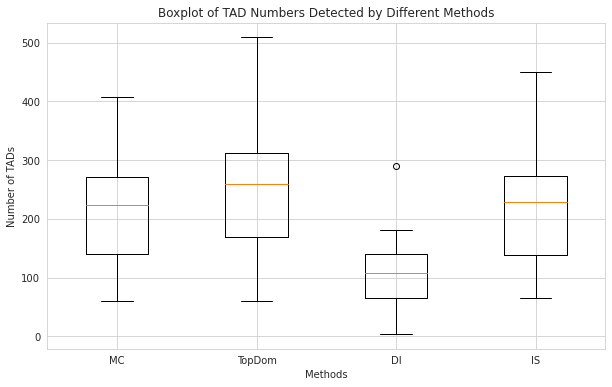

In [54]:
mc_number_list, mc_size_list = count_mathods_TADs_size_and_length(mctad_result_list)
tp_number_list, tp_size_list = count_mathods_TADs_size_and_length(topdom_result_list)
di_number_list, do_size_list = count_mathods_TADs_size_and_length(di_result_list)
is_number_list, is_size_list = count_mathods_TADs_size_and_length(is_result_list)
all_number_lists = [mc_number_list, tp_number_list, di_number_list, is_number_list]

# Labels for the boxplot
labels = ['MC', 'TopDom', 'DI', 'IS']

# Plotting the boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(all_number_lists, labels=labels)
plt.title('Boxplot of TAD Numbers Detected by Different Methods')
plt.ylabel('Number of TADs')
plt.xlabel('Methods')
plt.grid(True)

plt.show()

### Figure 2 B

4.85351989505903	21.709663314385658	56.864888500218626	100
9.060834405440177	27.936041168902776	61.07333210806837	100
3.4223706176961604	14.085976627712855	52.31636060100166	100
0.7792207792207793	4.805194805194805	15.584415584415584	100


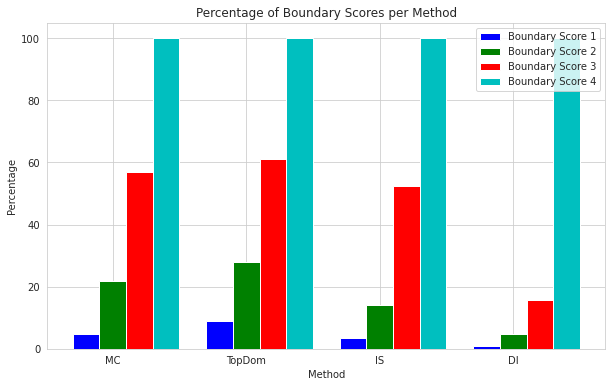

In [62]:
# Combine all result lists
all_result_list = [mctad_result_list, topdom_result_list, is_result_list, di_result_list]

# Calculate the boundary scores using the provided function
score_result = compare_boundary_score(all_result_list, 3)

# Initialize a list to store the calculated percentages
score_list = []

# Calculate the counts and percentages for each method
for method_scores in score_result:
    count1 = count2 = count3 = count4 = 0

    for scores in method_scores:
        count1 += scores.count(1)
        count2 += scores.count(2)
        count3 += scores.count(3)
        count4 += scores.count(4)

    total = count1 + count2 + count3 + count4
    percentages = [
        (count1 / total) * 100,
        ((count1 + count2) / total) * 100,
        ((count1 + count2 + count3) / total) * 100,
        100  # Since ((count1 + count2 + count3 + count4) / total) * 100 is always 100%
    ]

    print('\t'.join(map(str, percentages)))
    score_list.append(percentages)

# Convert score list to a NumPy array for plotting
data = np.array(score_list)

# Plotting the data
bar_width = 0.2
index = np.arange(data.shape[0])

plt.figure(figsize=(10, 6))

# Plot each boundary score percentage
for i in range(data.shape[1]):
    plt.bar(index + i * bar_width, data[:, i], bar_width, label=f'Boundary Score {i + 1}', color=colors[i])

# Adding labels and title
plt.xlabel('Method')
plt.ylabel('Percentage')
plt.title('Percentage of Boundary Scores per Method')
plt.xticks(index + bar_width, ['MC', 'TopDom', 'IS', 'DI'])
plt.legend()

plt.grid(True)
plt.show()

### Figure 2 C

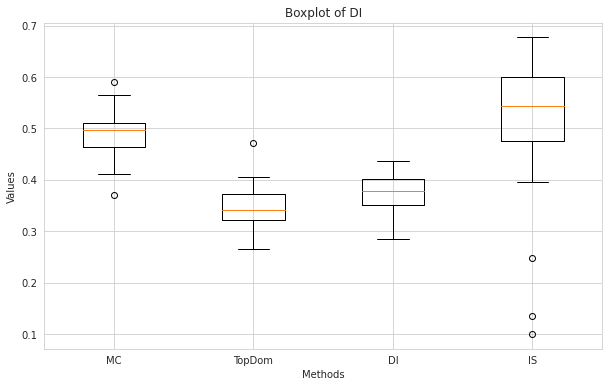

In [105]:
insulation_list = get_insulation_score_list('/mnt/disk3/duanran/mactop/{0}_result/03.IS_Result'.format('GM12878'))
mc_samp = compare_insulation_results(mctad_result_list, insulation_list)
top_samp = compare_insulation_results(topdom_result_list, insulation_list)
di_samp = compare_insulation_results(di_result_list, insulation_list)
is_samp = compare_insulation_results(is_result_list, insulation_list)
x = np.concatenate((mc_samp, top_samp, di_samp, is_samp), axis=0)
xx =[]
yy = []
for vv in x:
    xx.append(-vv)
for vv in xx:
    if vv < 1000:
        yy.append(vv+1000)
    else:
        yy.append(vv)
re = normalization(yy)

# Split the data into four groups, each with 23 numbers
method_data = [re[i:i + 23] for i in range(0, 92, 23)]

# Labels for the boxplot
labels = ['MC', 'TopDom', 'DI', 'IS']

# Plotting the boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(method_data, labels=labels)
plt.title('Boxplot of DI')
plt.ylabel('Values')
plt.xlabel('Methods')
plt.grid(True)

plt.show()

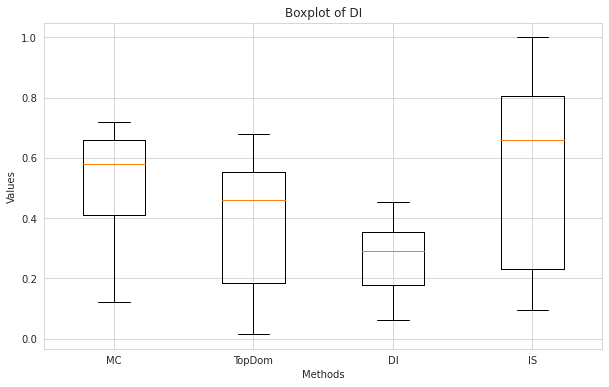

0    0.628207
1    0.678186
2    0.667820
3    0.426187
4    0.665896
Name: DirectionScore, dtype: float64


In [106]:
di_score_list = get_DI_score_list('/home/rduan/perl_scripts')
mc_samp = compare_insulation_results(mctad_result_list, di_score_list)
top_samp = compare_insulation_results(topdom_result_list, di_score_list)
di_samp = compare_insulation_results(di_result_list, di_score_list)
is_samp = compare_insulation_results(is_result_list, di_score_list)
x = np.concatenate((mc_samp, top_samp, di_samp, is_samp), axis=0)
xx =[]
yy = []
for vv in x:
    xx.append(-vv)
for vv in xx:
    if vv < 1000:
        yy.append(vv+1000)
    else:
        yy.append(vv)
re = normalization(yy)


# Split the data into four groups, each with 23 numbers
method_data = [re[i:i + 23] for i in range(0, 92, 23)]

# Labels for the boxplot
labels = ['MC', 'TopDom', 'DI', 'IS']

# Plotting the boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(method_data, labels=labels)
plt.title('Boxplot of DI')
plt.ylabel('Values')
plt.xlabel('Methods')
plt.grid(True)

plt.show()
print(re.head())

### Figure 2 D

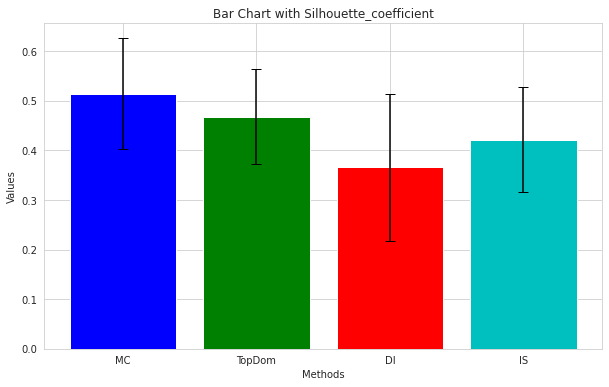

In [157]:
mc_sico_list = compare_Silhouette_coefficient('/mnt/disk1/duanran/{0}dense'.format(celline), mctad_result_list, mat_len_list, celline)
top_sico_list = compare_Silhouette_coefficient('/mnt/disk1/duanran/{0}dense'.format(celline), topdom_result_list, mat_len_list, celline)
di_sico_list = compare_Silhouette_coefficient('/mnt/disk1/duanran/{0}dense'.format(celline), di_result_list, mat_len_list,celline)
is_sico_list = compare_Silhouette_coefficient('/mnt/disk1/duanran/{0}dense'.format(celline), is_result_list, mat_len_list, celline)
x = np.concatenate((mc_sico_list,top_sico_list,di_sico_list,is_sico_list), axis=0)
re = x
# Split the data into four groups, each with 23 numbers
method_data = [re[i:i + 23] for i in range(0, 92, 23)]

# Calculate mean and standard deviation for each group
means = [np.mean(method) for method in method_data]
std_devs = [np.std(method) for method in method_data]

# Labels for the bar chart
labels = ['MC', 'TopDom', 'DI', 'IS']

# Plotting the bar chart with error bars
plt.figure(figsize=(10, 6))
plt.bar(labels, means, yerr=std_devs, capsize=5, color=['b', 'g', 'r', 'c'])
plt.title('Bar Chart with Silhouette_coefficient')
plt.ylabel('Values')
plt.xlabel('Methods')
plt.grid(True)

plt.show()

### Figure 2 E

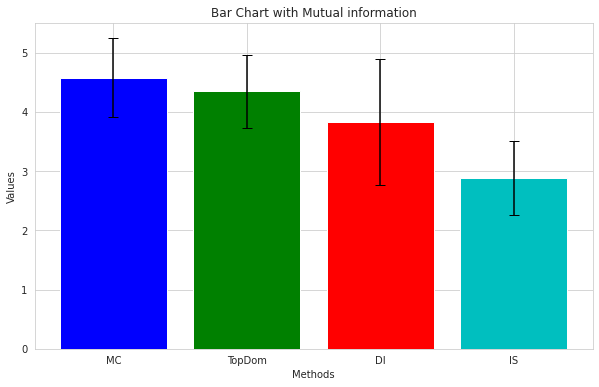

In [161]:
# Define the function to calculate MI list to labels and mutual information score
def calculate_mi_list(result_list_25kb, result_list_100kb, result_list, mat_len_list):
    mi_list = []
    for index in range(len(result_list_25kb)):
        mat_len = mat_len_list[index]
        kb_25 = MI_list_to_labes(np.ceil(result_list_25kb[index] / 2).astype(int), mat_len)
        kb_100 = MI_list_to_labes((result_list_100kb[index] * 2).astype(int), mat_len)
        kb_50 = MI_list_to_labes(result_list[index].astype(int), mat_len)
        value = metrics.mutual_info_score(kb_25, kb_100)
        mi_list.append(value)
    return mi_list

# MC method
mc_result_list = mctad_result_format2('/home/rduan/utad/algorithm/{0}re'.format(celline), 550)
mc_100kb_result_list = mctad_100kb_result_format("/home/rduan/utad/algorithm/{0}_100kb_re".format(celline), 550, celline)
mc_25kb_result_list = mctad_25kb_result_format("/home/rduan/utad/algorithm/{0}_25kb_re".format(celline), 550, celline)
mc_mi_list = calculate_mi_list(mc_25kb_result_list, mc_100kb_result_list, mc_result_list, mat_len_list)

# TopDom method
topdom_result_list = topdom_result_list
topdom_100kb_result_list = topdom_100kb_result_format('/home/rduan/topdom/result', celline)
topdom_25kb_result_list = topdom_25kb_result_format('/home/rduan/topdom/result', celline)
top_mi_list = calculate_mi_list(topdom_25kb_result_list, topdom_100kb_result_list, topdom_result_list, mat_len_list)

# DI method
di_result_list = di_result_list
di_25kb_result_list = di_25kb_result_format('/home/rduan/perl_scripts/result', celline)
di_100kb_result_list = di_100kb_result_format('/home/rduan/perl_scripts/result', celline)
di_mi_list = calculate_mi_list(di_25kb_result_list, di_100kb_result_list, di_result_list, mat_len_list)

# IS method
is_result_list = is_result_list
is_25kb_result_list = insulation_25kb_result_format('/home/rduan/insulationscore/crane-nature-2015-master/scripts/kb25', celline)
is_100kb_result_list = insulation_100kb_result_format('/home/rduan/insulationscore/crane-nature-2015-master/scripts/kb100', celline)
is_mi_list = calculate_mi_list(is_25kb_result_list, is_100kb_result_list, is_result_list, mat_len_list)

# Aggregate all MI lists
all_mi_lists = [mc_mi_list, top_mi_list, di_mi_list, is_mi_list]

# Calculate mean and standard deviation for each method
means = [np.mean(mi_list) for mi_list in all_mi_lists]
std_devs = [np.std(mi_list) for mi_list in all_mi_lists]

# Labels for the bar chart
labels = ['MC', 'TopDom', 'DI', 'IS']

# Plotting the bar chart with error bars
plt.figure(figsize=(10, 6))
plt.bar(labels, means, yerr=std_devs, capsize=5, color=['b', 'g', 'r', 'c'])
plt.title('Bar Chart with Mutual Information')
plt.ylabel('Values')
plt.xlabel('Methods')
plt.grid(True)
plt.show()

### Figure 2 F

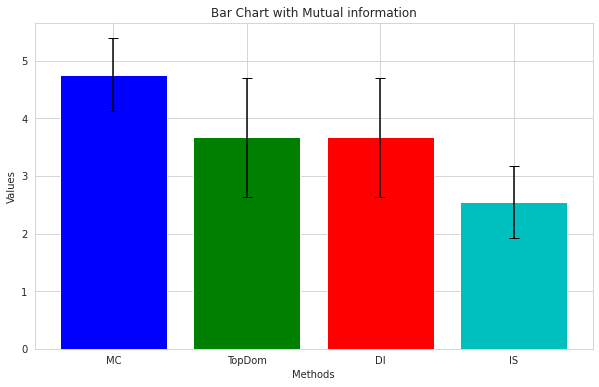

In [187]:
# Define the cell line and initialize lists for mutual information scores
celline = 'GM12878'
top_mi_down_list, mc_mi_down_list, di_mi_down_list, is_mi_down_list = [], [], [], []

# Define paths and fetch down-sampled results
topdom_down_results = [down_samping_topdom_result_format('/home/rduan/topdom/result', cell) for cell in ['HMEC', 'HUVEC', 'K562']]
mc_down_results = [down_samping_mctad_result_format('/home/rduan/utad/algorithm/down_samping_re', 550, cell) for cell in ['HMEC', 'HUVEC', 'K562']]
di_down_results = [down_samping_di_result_format('/home/rduan/perl_scripts/result', cell) for cell in ['HMEC', 'HUVEC', 'K562']]
is_down_results = [down_samping_insulation_result_format('/home/rduan/insulationscore/crane-nature-2015-master/scripts/GM12878_low', cell) for cell in ['HMEC', 'HUVEC', 'K562']]

# Calculate mutual information scores for each method
top_mi_down_list = calculate_mi_for_method(topdom_result_list, topdom_down_results[1], mat_len_list)
mc_mi_down_list = calculate_mi_for_method(mc_result_list, mc_down_results[1], mat_len_list)
di_mi_down_list = calculate_mi_for_method(di_result_list, di_down_results[1], mat_len_list)
is_mi_down_list = calculate_mi_for_method(is_result_list, is_down_results[1], mat_len_list)

# Concatenate all MI lists for analysis
all_mi_down_lists = [mc_mi_down_list, top_mi_down_list, di_mi_down_list, is_mi_down_list]

# Calculate mean and standard deviation for each method
means = [np.mean(mi_list) for mi_list in all_mi_down_lists]
std_devs = [np.std(mi_list) for mi_list in all_mi_down_lists]

# Labels for the bar chart
labels = ['MC', 'TopDom', 'DI', 'IS']

# Plotting the bar chart with error bars
plt.figure(figsize=(10, 6))
plt.bar(labels, means, yerr=std_devs, capsize=5, color=['b', 'g', 'r', 'c'])
plt.title('Bar Chart with Mutual Information for Down-Sampled Data')
plt.ylabel('Values')
plt.xlabel('Methods')
plt.grid(True)
plt.show()

### Figure 2 G

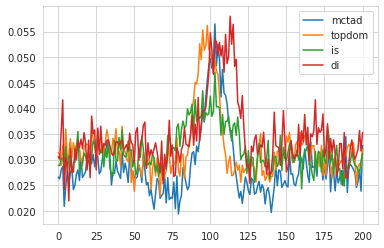

In [15]:
celline = ['GM12878','HMEC','HUVEC','K562',"NHEK"]
celline = 'GM12878'
mat_len_list = np.loadtxt('/home/rduan/utad/algorithm/hunmen_gens_length', dtype=np.int)
mc_result_list = mactop_result_format_1('/home/rduan/utad/algorithm/{0}re'.format(celline), 0.8)
is_result_list = insulation_result_format_1('/home/rduan/insulationscore/crane-nature-2015-master/scripts/{0}'.format(celline),celline)
di_result_list = di_result_format_1('/home/rduan/perl_scripts/{0}result'.format(celline), celline)
top_result_list = topdom_result_format_1('/home/rduan/topdom/result',celline)
maths_list = [mc_result_list,top_result_list,is_result_list,di_result_list]
ctcf_path = '/home/rduan/utad/algorithm/histonepeakfile/wgEncodeAwgTfbsHaibGm12878Rad21V0416101UniPk.narrowPeak'
# ctcf_path = '/mnt/disk3/duanran/HistonPeakFile/wgEncodeBroadHistoneGm12878H3k4me3StdPk.broadPeak.gz'
# /mnt/disk3/duanran/HistonPeakFile/wgEncodeBroadHistoneGm12878H3k4me3StdPk.broadPeak.gz
# wgEncodeAwgTfbsSydhGm12878Smc3ab9263IggmusUniPk.narrowPeak
# wgEncodeAwgTfbsHaibGm12878Rad21V0416101UniPk.narrowPeak
# wgEncodeAwgTfbsBroadGM12878CtcfUniPk.narrowPeak
final_list = []
for single_method in maths_list:
    all_fin_list = np.zeros(201)
    for chrnum in range(1,20):
        mat_len = mat_len_list[chrnum-1]*10
        resulution = 5000
        scale = 100
        ctct_list = get_CTCF_makerlist(ctcf_path, chrnum ,mat_len,resulution)

        cmm = single_method[chrnum-1]
        new_loc = []
        for boundary in cmm:
            new_loc.append((boundary-1)*10+3)
        new_loc = np.array(new_loc,dtype=np.int)

        fin_list = np.array([0]*201)
        for boundary in new_loc:
            if boundary - scale > 0 and boundary + scale < mat_len:
                fin_list = fin_list + ctct_list[boundary-scale:boundary+scale+1]
        fin_list = fin_list / len(new_loc)
        fin_list = np.array(fin_list)
        for index in range(201):
            all_fin_list[index] += fin_list[index]

    final_list.append(all_fin_list/22)

# 绘制fin_list折线图
x = np.arange(0,201,1)
plt.plot(x,final_list[0],label='mctad')
plt.plot(x,final_list[1],label='topdom')
plt.plot(x,final_list[2],label='is')
plt.plot(x,final_list[3],label='di')
plt.legend()
plt.show()

run
Directionality	H3k4me1	0.019892245260739044
Insulation	H3k4me1	0.03220394905483186
TopDom	H3k4me1	0.021295300079647708
MCTad	H3k4me1	0.044318135912997526
Directionality	H3k4me2	0.018017664095462953
Insulation	H3k4me2	0.033804878417507546
TopDom	H3k4me2	0.021901317059460745
MCTad	H3k4me2	0.0437971533774018
Directionality	H3k4me3	0.01986931358736405
Insulation	H3k4me3	0.03379430107525787
TopDom	H3k4me3	0.024397733514754615
MCTad	H3k4me3	0.042682694790123585
Directionality	H3k9ac	0.021828772621738518
Insulation	H3k9ac	0.034918199146982916
TopDom	H3k9ac	0.026665723723213196
MCTad	H3k9ac	0.04696631011956137
Directionality	H3k9me3	0.025781831594938683
Insulation	H3k9me3	0.042456530540452134
TopDom	H3k9me3	0.03833934001837159
MCTad	H3k9me3	0.04104916497522463
Directionality	H3k27ac	0.02874526296862981
Insulation	H3k27ac	0.034532805066341404
TopDom	H3k27ac	0.026987042433233733
MCTad	H3k27ac	0.042653816682081167
Directionality	H3k27me3	0.04067865589624104
Insulation	H3k27me3	0.0392491631880

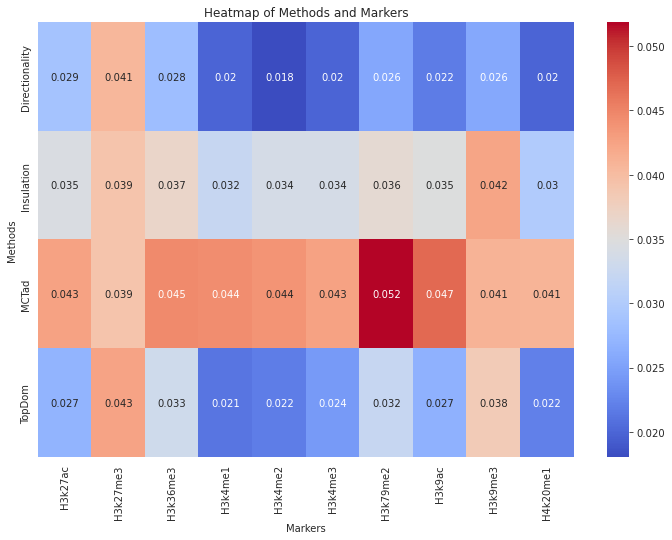

In [207]:
# 计算H3k4me2等蛋白在TADs中的富集情况
mathod_name = ['Directionality','Insulation','TopDom','MCTad']
celline = 'Gm12878'
mathods_list=[]
mathods_list.append(di_result_list)
mathods_list.append(is_result_list)
mathods_list.append(top_result_list)
mathods_list.append(mc_result_list)

# shuffle_tad = get_shuffle_tad(mc_result_list[1])
aa = open('./histone_name.txt')
ctct_name_list = []
for lin in aa :
    ctct_name_list.append(lin.strip())
aa.close()
heatmap_list = []
for ctcf_name in ctct_name_list:
    ctcf_path = '/mnt/disk3/duanran/HistonPeakFile/wgEncodeBroadHistone{0}{1}StdPk.broadPeak.gz'.format(celline,ctcf_name)
    resulution = 50000
    name_index = 0
    for methods in mathods_list:
        m_name = mathod_name[name_index]
        name_index += 1
        sum_all = 0
        # print(m_name)
        math_number = 0
        for chrnum in range(len(methods)):
            mat_len = mat_len_list[chrnum]
            ctct_list = get_CTCF_makerlist(ctcf_path, chrnum+1, mat_len, resulution)
            chr_result = methods[chrnum]
            count = 0
            begin = 0
            backgroud = get_10x_shuffle_result(chr_result, ctct_list)
            for re in chr_result:
                if np.sum(ctct_list[begin:re]) > backgroud:
                    count += 1
                begin = re
            math_number += (count/len(chr_result))
        print('{0}\t{1}\t{2}'.format(m_name,ctcf_name,math_number/23))
        heatmap_list.append([m_name,ctcf_name,math_number/23])
data = heatmap_list
# Extracting data into appropriate format for heatmap
methods = sorted(set(item[0] for item in data))
markers = sorted(set(item[1] for item in data))
heatmap_data = np.zeros((len(methods), len(markers)))

# Fill the heatmap data array
for method, marker, value in data:
    method_idx = methods.index(method)
    marker_idx = markers.index(marker)
    heatmap_data[method_idx, marker_idx] = value

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', xticklabels=markers, yticklabels=methods)
plt.title('Heatmap of Methods and Markers')
plt.xlabel('Markers')
plt.ylabel('Methods')
plt.show()


## Figure 3

### Figure 3 B

In [724]:
stable_boundary,dynamic_boundary,blurry_boundary,boundary_markers = mactop_result_load()

stable : 3067  unstalbe : 1657  bad : 256


### Figure 3 C

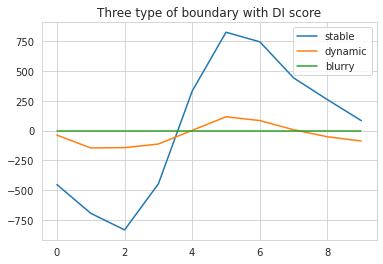

In [662]:
stable_di = compare_insulation_results2(stable_boundary, di_score_list)
dynamic_di = compare_insulation_results2(dynamic_boundary, di_score_list)
blurry_di = compare_insulation_results2(blurry_boundary, di_score_list)
x = np.arange(0,10,1)
plt.plot(x,stable_di,label='stable')
plt.plot(x,dynamic_di,label='dynamic')
plt.plot(x,blurry_di,label='blurry')
plt.title('Three type of boundary with DI score')
plt.legend()
plt.show()

### Figure 3 D

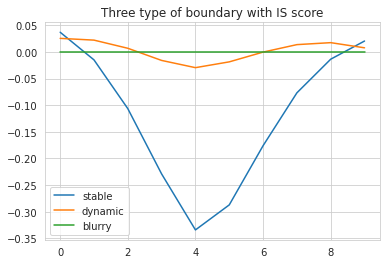

In [663]:
stable_di = compare_insulation_results2(stable_boundary, insulation_list)
dynamic_di = compare_insulation_results2(dynamic_boundary, insulation_list)
blurry_di = compare_insulation_results2(blurry_boundary, insulation_list)
x = np.arange(0,10,1)
plt.plot(x,stable_di,label='stable')
plt.plot(x,dynamic_di,label='dynamic')
plt.plot(x,blurry_di,label='blurry')
plt.title('Three type of boundary with IS score')
plt.legend()
plt.show()

### Figure 3 E

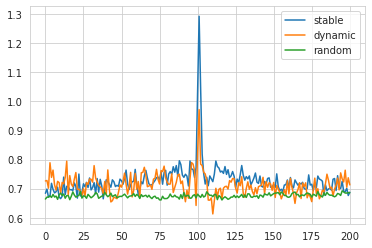

In [704]:
celline = 'GM12878'
ranbo = get_random_boundary_list(mat_len_list)
maths_list = [stable_boundary,dynamic_boundary,ranbo]
ctcf_path = '/home/rduan/utad/algorithm/histonepeakfile/wgEncodeAwgTfbsBroadGM12878CtcfUniPk.narrowPeak'
final_list = []
for single_method in maths_list:
    all_fin_list = np.zeros(201)
    for chrnum in range(1,20):
        mat_len = mat_len_list[chrnum-1]
        resulution = 50000
        scale = 100
        ctct_list = get_CTCF_makerlist(ctcf_path, chrnum ,mat_len,resulution)
        cmm = single_method[chrnum-1]
        new_loc = []
        for boundary in cmm:
            # new_loc.append((boundary-1)*10+5)
            new_loc.append(boundary)
        # begin_ll = 0
        # for boundary in cmm:
        #     # new_loc.append((boundary-1)*10+3)
        #     new_loc.append(int((begin_ll + boundary)/2))
        #     begin_ll = boundary

        new_loc = np.array(new_loc,dtype=np.int)

        fin_list = np.array([0]*201)
        for boundary in new_loc:
            if boundary - scale > 0 and boundary + scale < mat_len:
                fin_list = fin_list + ctct_list[boundary-scale:boundary+scale+1]
        fin_list = fin_list / len(new_loc)
        fin_list = np.array(fin_list)
        for index in range(201):
            all_fin_list[index] += fin_list[index]

    final_list.append(all_fin_list/20)

# 绘制fin_list折线图
x = np.arange(0,201,1)
plt.plot(x,final_list[0],label='stable')
plt.plot(x,final_list[1],label='dynamic')
plt.plot(x,final_list[2],label='random')
plt.legend()
plt.show()

### Figure 3 F

Stable : 3067  Dynamic    : 1657  Blurry    : 256


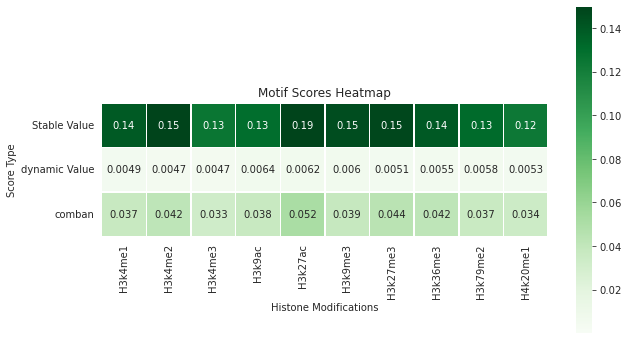

In [12]:

def mactop_result_load2():
    celline = 'GM12878'
    result_list, boundary_list, prob_list = mactop_result_format('/mnt/disk3/duanran/mactop/{0}_result/mactop_result'.
                                                                 format(celline), 550)
    stable_boundary = []
    unstable_boundary = []
    bad_boundary = []

    boundary_markers = []

    flag_s = 0
    flag_u = 0
    flag_b = 0
    all_num = 0
    for chrnum in range(len(boundary_list)):
        all_num += np.size(boundary_list[chrnum])
        aim_boundary = boundary_list[chrnum]
        aim_prob = prob_list[chrnum]
        st_list = []
        unst_list = []
        bd_list = []
        boundary_marker = []
        for index in range(np.size(aim_boundary)):
            if aim_prob[index] < 5:
                flag_s +=1
                boundary_marker.append(1)
                st_list.append(aim_boundary[index])
            if aim_prob[index] > 50:
                flag_b +=1
                bd_list.append(aim_boundary[index])
                boundary_marker.append(2)
            if aim_prob[index] >=10 and aim_prob[index] <= 50:
                flag_u +=1
                unst_list.append(aim_boundary[index])
                boundary_marker.append(3)
        stable_boundary.append(st_list)
        unstable_boundary.append(unst_list)
        bad_boundary.append(bd_list)
        boundary_markers.append(boundary_marker)
    print("Stable : {0}  Dynamic    : {1}  Blurry    : {2}".format(flag_s, flag_u, flag_b))
    return boundary_act(stable_boundary),boundary_act(unstable_boundary),boundary_act(bad_boundary),boundary_markers,result_list
    # return stable_boundary,unstable_boundary,bad_boundary,boundary_markers

insulation_list = get_insulation_score_list('/mnt/disk3/duanran/mactop/{0}_result/03.IS_Result'.format('GM12878'))
celline = 'GM12878'
mc_result_list = mactop_result_format_1('/home/rduan/utad/algorithm/{0}re'.format(celline), 0.8)
mat_len_list = np.loadtxt('/home/rduan/utad/algorithm/hunmen_gens_length', dtype=np.int)

stable_boundary,dynamic_boundary,blurry_boundary,boundary_markers,mc2_result_list = mactop_result_load2()
method_name = ['Mactop']
celline = 'Gm12878'
methods_list = [mc2_result_list]

# TAD type
boundary_counts = []
tad_marks = []
for boundaries in boundary_markers:
    count_dict = {'aa': 0, 'ab': 0, 'ba': 0, 'bb': 0, 'cc': 0}
    tad_mark = []
    prev_marker = 1
    for end in boundaries:
        if prev_marker == 1 and end == 1:
            tad_mark.append(1)
            count_dict['aa'] += 1
        elif prev_marker == 1 and end == 3:
            tad_mark.append(2)
            count_dict['ab'] += 1
        elif prev_marker == 3 and end == 1:
            tad_mark.append(2)
            count_dict['ba'] += 1
        elif prev_marker == 3 and end == 3:
            tad_mark.append(2)
            count_dict['bb'] += 1
        else:
            tad_mark.append(3)
            count_dict['cc'] += 1
        prev_marker = end
    boundary_counts.append(list(count_dict.values()))
    tad_marks.append(tad_mark)

with open('./histone_name.txt') as file:
    histone_names = [line.strip() for line in file]

# background 
motif_scores_stable = []
motif_scores_dynamic = []
motif_scores_tad = []
resolution = 50000
for histone_name in histone_names:
    histone_path = f'/mnt/disk3/duanran/HistonPeakFile/wgEncodeBroadHistone{celline}{histone_name}StdPk.broadPeak.gz'
    for method, method_name in zip(methods_list, method_name):
        total_stable_score = 0
        total_dynamic_score = 0
        total_tad_score = 0
        tad_scores = []
        for chr_idx, chr_result in enumerate(method):
            mat_len = mat_len_list[chr_idx]
            ctcf_list = get_CTCF_makerlist(histone_path, chr_idx + 1, mat_len, resolution)
            background_stable, background_dynamic= get_10x_shuffle_result_with_diff_boundary_type(chr_result, ctcf_list,tad_marks[chr_idx])

            chr_scores = []
            begin_position = 0
            tad_index = 0
            stable_tad_pvalue = []
            dynamic_tad_pvalue = []
            for end_position in mc2_result_list[chr_idx]:
                chr_scores = ctcf_list[begin_position:end_position]
                begin_position = end_position
                if tad_marks[chr_idx][tad_index] == 1:
                    if np.sum(chr_scores) > background_stable:
                        stable_tad_pvalue.append(1)
                else:
                    if np.sum(chr_scores) > background_dynamic:
                        dynamic_tad_pvalue.append(1)
            sta_tad_num = 0
            dyn_tad_num = 0
            for vvv in tad_mark:
                if vvv == 1:
                    sta_tad_num +=1
                else:
                    dyn_tad_num +=1
            sta_value = np.sum(stable_tad_pvalue)/sta_tad_num
            dny_value = np.sum(dynamic_tad_pvalue)/dyn_tad_num
            tad_value = (np.sum(stable_tad_pvalue)+np.sum(dynamic_tad_pvalue))/len(tad_marks[chr_idx])
            total_stable_score += sta_value
            total_dynamic_score += dny_value
            total_tad_score += tad_value

    motif_scores_stable.append(total_stable_score)
    motif_scores_dynamic.append(total_dynamic_score)
    motif_scores_tad.append(total_tad_score)

finale_stable = np.array(motif_scores_stable)/len(mc2_result_list)
finale_dynamic = np.array(motif_scores_dynamic)/len(mc2_result_list)
finale_tad = np.array(motif_scores_tad)/len(mc2_result_list)
data = np.vstack([finale_stable,finale_dynamic, finale_tad])
labels = ['Stable Value','dynamic Value', 'comban']

plt.figure(figsize=(10, 6))
sns.heatmap(data, cmap='Greens', annot=True,vmax=0.15,vmin=0.0001, xticklabels=histone_names, yticklabels=labels,linewidths=.5, square=True)
plt.title('Motif Scores Heatmap')
plt.xlabel('Histone Modifications')
plt.ylabel('Score Type')
plt.show()

### Figure 3 G

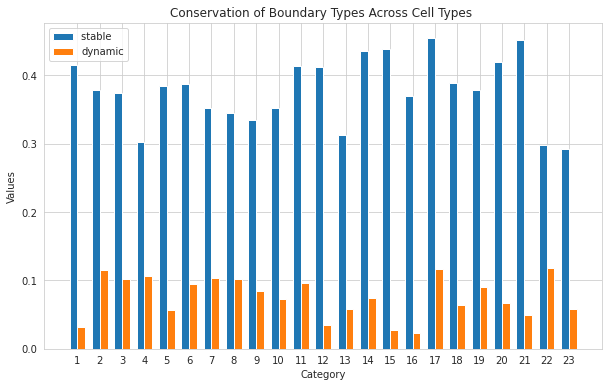

In [743]:
st_val,dy_val = cross_cell_boundary_compare('GM12878','K562')
value_list1 = st_val
value_list2 = dy_val

x = np.arange(len(value_list1))

bar_width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x, value_list1, width=bar_width, label='stable ')
plt.bar(x + bar_width, value_list2, width=bar_width, label='dynamic')

plt.xlabel('Category')
plt.ylabel('Values')
plt.title('Conservation of Boundary Types Across Cell Types ')
plt.xticks(x + bar_width / 2, [f'{i+1}' for i in range(len(value_list1))])
plt.legend()

# 显示图表
plt.show()

## Figure 4

### Figure 4 A

/home/rduan/anaconda3/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


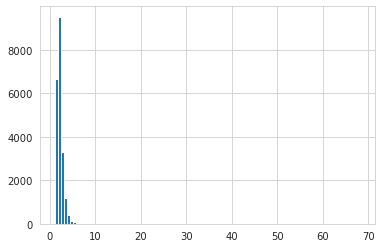

<Figure size 720x720 with 0 Axes>

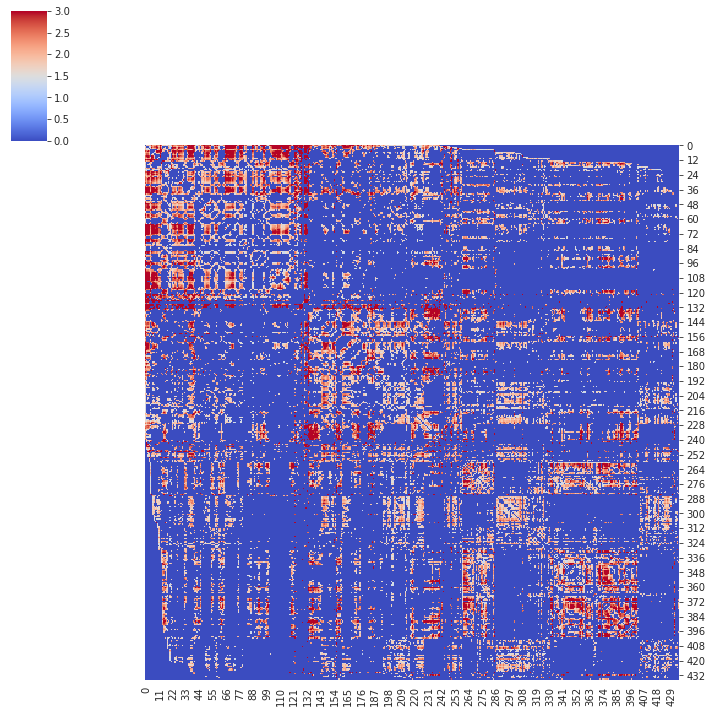

In [859]:
lens_list = []
community_list = []
celline = 'GM12878'
precentile = 95
mactop_result_list = mctad_result_format_3('/home/rduan/utad/algorithm/{0}re'.format(celline), 0.95)
chr_num = 2
result_list = mactop_result_list[chr_num-1]
tad_list = get_tad_list(result_list)
dense_mat = np.loadtxt('/mnt/disk1/duanran/GM12878dense/GM12878{0}'.format(chr_num))
diag_mat = get_diag_norm_mat(dense_mat)

node_one_list = []
node_two_list = []
count_list = []
for index in range(len(tad_list)):
    for index2 in range(index+1,len(tad_list)):
        tad_one = tad_list[index]
        tad_two = tad_list[index2]
        tad_one_begin = tad_one[0]
        tad_one_end = tad_one[1]
        tad_two_begin = tad_two[0]
        tad_two_end = tad_two[1]
        ot_conut = diag_mat[tad_two_begin:tad_two_end+1, tad_one_begin:tad_one_end+1]
        weight_ori = np.sum(ot_conut)/((tad_two_end-tad_two_begin)*(tad_one_end-tad_one_begin))
        t_statistic, p_value = significance(diag_mat,tad_one,tad_two)
        if t_statistic > 0 and p_value < 0.01:
            node_one_list.append(index)
            node_two_list.append(index2)
            count_list.append(weight_ori)
df = pd.DataFrame({'node_one':node_one_list, 'node_two':node_two_list, 'weight':count_list})
df_for_net = pd.DataFrame({'source':node_one_list, 'target':node_two_list, 'Weight':count_list})

plt.hist(df['weight'], bins=100)
plt.show()

G = nx.from_pandas_edgelist(df, 'node_one', 'node_two', edge_attr='weight')
adj_mat = nx.to_numpy_matrix(G)
plt.figure(figsize=(10, 10))
sns.clustermap(adj_mat, row_cluster=False, col_cluster=False ,cmap='coolwarm',vmin = 0, vmax = 3)
plt.show()

### Figure 4 B

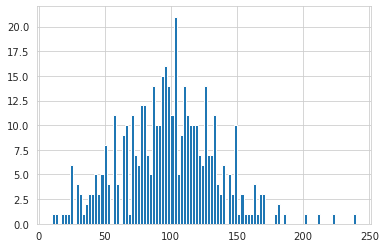

In [764]:
all_pairs_shortest_path = dict(nx.all_pairs_dijkstra_path(G, weight='weight'))

path_list = []
for source_node, shortest_paths in all_pairs_shortest_path.items():
    for target_node, path in shortest_paths.items():
        if source_node != target_node:
            path_list.append(len(path))
# 绘制path_list的直方图
# plt.hist(path_list, bins=100)
# plt.show()
# 保存path_list到/mnt/disk3/duanran/TAD_net/path_list_95_{0}.csv
path_list_df = pd.DataFrame({'path':path_list})
# path_list_df.to_csv('/mnt/disk3/duanran/TAD_net/path_list_pvalue_{0}_{1}.csv'.format(precentile,chr_num), index=False)

# 计算度分布
degree_sequence = [degree for node, degree in G.degree()]
# 绘制度分布
plt.hist(degree_sequence, bins=100)
plt.show()



### Figure 4 C

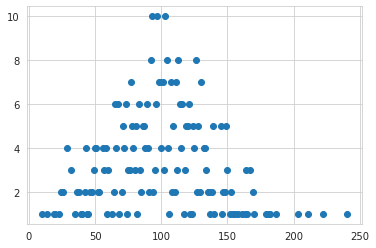

In [765]:
degree_sequence_count = Counter(degree_sequence)
plt.scatter(degree_sequence_count.keys(), degree_sequence_count.values())
plt.show()

### Figure 4 E

Calculating best minimal value for power law fit


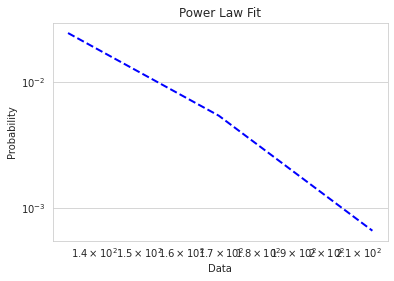

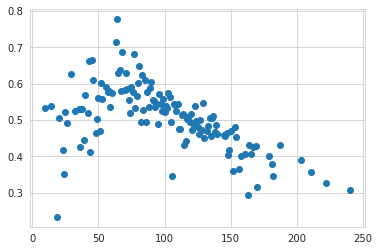

In [767]:
fit = powerlaw.Fit(degree_sequence)
alpha = fit.alpha
fit.plot_pdf(color='b', linestyle='--', linewidth=2)
plt.xlabel('Data')
plt.ylabel('Probability')
plt.title('Power Law Fit')
plt.show()
degree_sequence_df = pd.DataFrame({'degree':degree_sequence})
# degree_sequence_df.to_csv('/mnt/disk3/duanran/TAD_net/degree_sequence_pvalue_{0}_{1}.csv'.format(precentile,chr_num), index=False)

degree_sequence.sort(reverse=True)

average_clustering_coefficient = nx.average_clustering(G)


clustering_coefficients = nx.clustering(G)

clustering_coefficients_df = pd.DataFrame({'node':list(clustering_coefficients.keys()), 'cc':list(clustering_coefficients.values())})
# 按照node排序
clustering_coefficients_df = clustering_coefficients_df.sort_values(by='node')

degree_dict = dict(G.degree())
degree_dict_node_list = []
degree_dict_deg_list = []
for node, degree in degree_dict.items():
    degree_dict_node_list.append(node)
    degree_dict_deg_list.append(degree)
degree_dict_df = pd.DataFrame({'node':degree_dict_node_list, 'degree':degree_dict_deg_list})
degree_dict_df = degree_dict_df.sort_values(by='node')

clustering_coefficients_df = pd.merge(clustering_coefficients_df, degree_dict_df, on='node')
clustering_coefficients_df = clustering_coefficients_df[clustering_coefficients_df['cc'] > 0]

# plt.scatter(clustering_coefficients_df['degree'], clustering_coefficients_df['cc'])
# plt.show()
degree_cc_mean = clustering_coefficients_df.groupby('degree')['cc'].mean()

# plt.scatter(degree_cc_mean.index, degree_cc_mean)
# plt.show()
degree_cc_mean_df = pd.DataFrame({'degree':degree_cc_mean.index, 'cc':degree_cc_mean.values})
plt.scatter(degree_cc_mean_df['degree'], degree_cc_mean_df['cc'])
plt.show()
# 保存degree_cc_mean_df到/mnt/disk3/duanran/TAD_net/degree_cc_mean_chr2_df.csv
# degree_cc_mean_df.to_csv('/mnt/disk3/duanran/TAD_net/degree_cc_mean_pvalue_chr2_df.csv', index=False)


### Figure 4 F

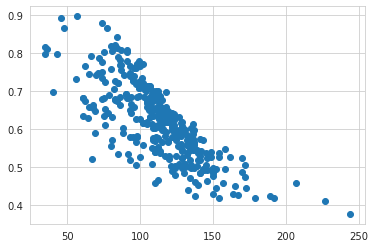

In [756]:
plt.scatter(clustering_coefficients_df['degree'],clustering_coefficients_df['cc'])
plt.show()

### Figure 4 H

/home/rduan/anaconda3/envs/python3.6/lib/python3.6/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/rduan/anaconda3/envs/python3.6/lib/python3.6/site-packages/seaborn/matrix.py:625: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)
/home/rduan/anaconda3/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/rduan/anaconda3/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

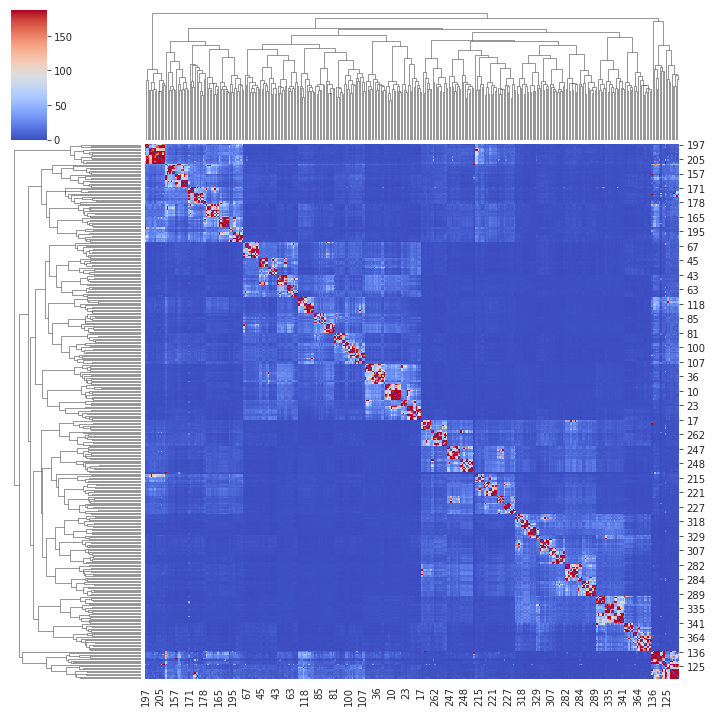

In [860]:
mactop_result_list = mctad_result_format_3('/home/rduan/utad/algorithm/{0}re'.format(celline), 0.8)
hic_mat = np.loadtxt('/mnt/disk1/duanran/GM12878dense/GM128782')
#
cluster_list , reordered_ind = get_cliques_result_nmat(hic_mat, mactop_result_list, 1)
resolution = 50000
df = pd.read_csv('/home/rduan/utad/algorithm/histonepeakfile/wgEncodeOpenChromDnaseGm12878Pk.narrowPeak', sep='\t', header=None)
df_chr2 = df[df[0] == 'chr2']
df_chr2[1] = df_chr2[1] // resolution
df_chr2[2] = df_chr2[2] // resolution
tad_list = get_tad_list(mactop_result_list[1])
cluster_list[0]
uncluster_list = []
for untad_index in range(len(tad_list)):
    if untad_index not in cluster_list[0]:
        uncluster_list.append(untad_index)
comunity_bins_list = []
for vv in cluster_list[0]:
    for bin in range(tad_list[vv][0]+1, tad_list[vv][1]):
        comunity_bins_list.append(bin)
comunity_open = 0
for index, row in df_chr2.iterrows():
    if row[1] in comunity_bins_list:
        comunity_open += 1
comunity_open/len(comunity_bins_list)
reordered_ind = np.array(reordered_ind)
sc_location = np.where(reordered_ind == 280)[0]
cc_list = reordered_ind[0:210]
uu_list = reordered_ind[210:len(reordered_ind)]
cc_list_bin = []
uu_list_bin = []
for vv in cc_list:
    for bins in range(tad_list[vv][0]+1, tad_list[vv][1]+1):
        cc_list_bin.append(bins)
for vv in uu_list:
    for bins in range(tad_list[vv][0]+1, tad_list[vv][1]+1):
        uu_list_bin.append(bins)
cc_list_bin = np.array(cc_list_bin)
uu_list_bin = np.array(uu_list_bin)
reordered_ind = np.array(reordered_ind)
sc_location = np.where(reordered_ind == 280)[0]
cc_list = reordered_ind[0:210]
uu_list = reordered_ind[210:len(reordered_ind)]
tad_list
cc_list_bin = []
uu_list_bin = []
for vv in cc_list:
    for bins in range(tad_list[vv][0]+1, tad_list[vv][1]+1):
        cc_list_bin.append(bins)
for vv in uu_list:
    for bins in range(tad_list[vv][0]+1, tad_list[vv][1]+1):
        uu_list_bin.append(bins)
cc_list_bin = np.array(cc_list_bin)
uu_list_bin = np.array(uu_list_bin)
comunity_open = 0
for index, row in df_chr2.iterrows():
    if row[1] in cc_list_bin:
        comunity_open += 1
comunity_open/len(cc_list_bin)
comunity_open = 0
for index, row in df_chr2.iterrows():
    if row[1] in uu_list_bin:
        comunity_open += 1
comunity_open/len(uu_list_bin)
cc_list_sort = np.sort(cc_list)
cc_list_sort_list = []
sub_list = []
for index in range(len(cc_list_sort)-1):
    if cc_list_sort[index+1] - cc_list_sort[index] == 1:
        sub_list.append(cc_list_sort[index])
    else:
        sub_list.append(cc_list_sort[index])
        cc_list_sort_list.append(sub_list)
        sub_list = []
lianxu_list = []
for vv in cc_list_sort_list:
    if len(vv) > 2:
        for vvv in vv:
            lianxu_list.append(vvv)
lianxu_bins_list = []
for vv in lianxu_list:
    for bins in range(tad_list[vv][0], tad_list[vv][1]+1):
        lianxu_bins_list.append(bins)

uu_list_sort = np.sort(uu_list)
# uu_list_sort中连续的元素单独形成一个list并添加到uu_list_sort_list中
uu_list_sort_list = []
sub_list = []
for index in range(len(uu_list_sort)-1):
    if uu_list_sort[index+1] - uu_list_sort[index] == 1:
        sub_list.append(uu_list_sort[index])
    else:
        sub_list.append(uu_list_sort[index])
        uu_list_sort_list.append(sub_list)
        sub_list = []

bulianxu_list = []
for vv in uu_list_sort_list:
    if len(vv) > 2:
        for vvv in vv:
            bulianxu_list.append(vvv)
bulianxu_bins_list = []
for vv in bulianxu_list:
    for bins in range(tad_list[vv][0], tad_list[vv][1]+1):
        bulianxu_bins_list.append(bins)
for chrnum in range(22):
    tadlist = get_tad_list(mactop_result_list[chrnum])
    tadlist = np.array(tadlist)
    tadlist = tadlist*50000
    chrname = 'chr'+str(chrnum+1)
    begin_list = []
    end_list = []
    name_list = []
    for binpair in tadlist:
        begin_list.append(binpair[0])
        end_list.append(binpair[1])
        name_list.append(chrname)
    # 构建一个dataframe，第一列为tad的编号，第二列为tad的起始位置，第三列为tad的终止位置
    df_tad = pd.DataFrame({'tad_index':name_list, 'begin':begin_list, 'end':end_list})
    df_tad.to_csv('/mnt/disk3/duanran/CODS/SDOC/GM12878_data_new/TADs/GM12878_chr{0}'.format(chrnum+1), sep='\t', index=False, header=False)


def compare_insulation_results3(results_list, biomaker_list):
    com_boundary_set = set()
    for sig_community in results_list:
        for tad_index in sig_community:
            com_boundary_set.add(tad_list[tad_index][0])
            com_boundary_set.add(tad_list[tad_index][1])
    resu = sorted(list(com_boundary_set))
    all_value = np.zeros(10)
    insu = biomaker_list
    for location in range(3, len(resu) - 3):
        invalue = insu[resu[location] - 5:resu[location] + 5]
        all_value = all_value + invalue
    all_value = all_value / (len(resu))

    value1 = 1 - (max(all_value)-min(all_value))

    return all_value

SODC_df = pd.read_csv('/mnt/disk3/duanran/CODS/SDOC/dr_test/GM12878/TAD_SDOC/raw_SDOC', sep='\t', header=None)
SODC_df_chr2 = SODC_df[SODC_df[0] == 'chr2']

SODC_df = pd.read_csv('/mnt/disk3/duanran/CODS/SDOC/dr_test/GM12878/TAD_SDOC/raw_SDOC', sep='\t', header=None)
SODC_df_chr2 = SODC_df[SODC_df[0] == 'chr2']
SODC_df_chr2_4 = np.array(SODC_df_chr2[5])



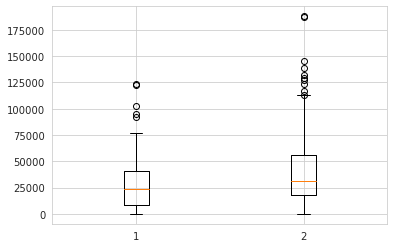

In [879]:
uu_sdoc_list = []
cc_sdoc_list = []
for vv in range(len(uu_list_sort)):
    if uu_list_sort[vv] < 400:
        uu_sdoc_list.append(SODC_df_chr2_4[uu_list_sort[vv]])

for vv in range(len(cc_list_sort)):
    if cc_list_sort[vv] < 400:
        cc_sdoc_list.append(SODC_df_chr2_4[cc_list_sort[vv]])
plt.boxplot([uu_sdoc_list, cc_sdoc_list])
plt.show()

### Figure 4 I

Calculating best minimal value for power law fit
This is H2A.Z: 99%
This is H3K4me3
This is H3K4me1
This is H3K4me2
This is H3K27ac
This is H3K27me3
This is H3K36me3
This is H3K9ac
This is H3K9me3
This is H3K79me2
This is CTCF
This is SMC3
This is RAD21
This is Pol2
This is YY1
This is DNA_methylation
This is DNase
This is Repli
This is RNA-
This is RNA+


/home/rduan/anaconda3/envs/python3.6/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


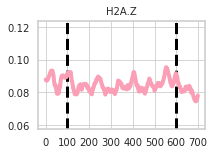

/home/rduan/anaconda3/envs/python3.6/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


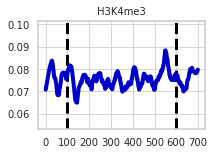

/home/rduan/anaconda3/envs/python3.6/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


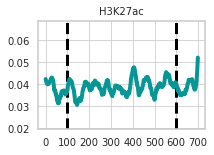

/home/rduan/anaconda3/envs/python3.6/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


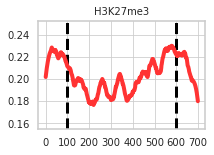

/home/rduan/anaconda3/envs/python3.6/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


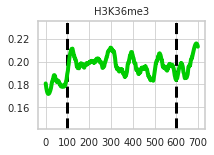

/home/rduan/anaconda3/envs/python3.6/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


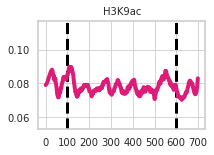

/home/rduan/anaconda3/envs/python3.6/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


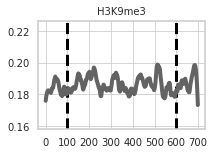

/home/rduan/anaconda3/envs/python3.6/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


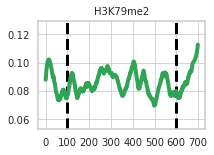

/home/rduan/anaconda3/envs/python3.6/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


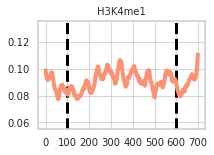

/home/rduan/anaconda3/envs/python3.6/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


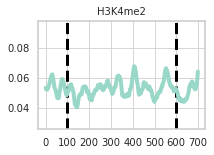

/home/rduan/anaconda3/envs/python3.6/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


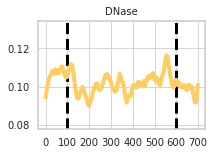

/home/rduan/anaconda3/envs/python3.6/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


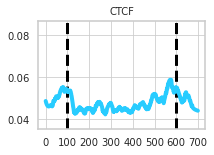

/home/rduan/anaconda3/envs/python3.6/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


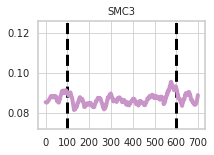

/home/rduan/anaconda3/envs/python3.6/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


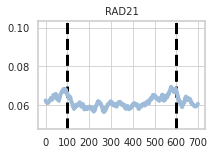

/home/rduan/anaconda3/envs/python3.6/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


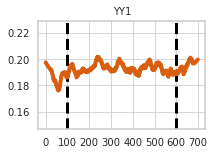

/home/rduan/anaconda3/envs/python3.6/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


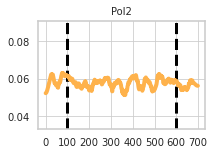

/home/rduan/anaconda3/envs/python3.6/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


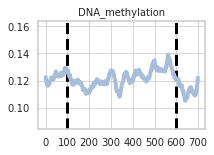

In [887]:
mactop_result_list = mctad_result_format_3('/home/rduan/utad/algorithm/{0}re'.format(celline), 0.95)
result_list = mactop_result_list[2-1]
tad_list = get_tad_list(result_list)
significance_tad_list = []
significance_tad_flag = 0
unsignificance_tad_flag = 0
for tad_a_index in range(len(tad_list)):
    for tad_b_index in range(tad_a_index+1,len(tad_list)):
        tad_a = tad_list[tad_a_index]
        tad_b = tad_list[tad_b_index]
        t_statistic, p_value = significance(diag_mat,tad_a,tad_b)
        if t_statistic > 0 and p_value < 0.05:
            significance_tad_list.append([tad_a,tad_b,t_statistic,p_value,tad_a_index,tad_b_index])
            significance_tad_flag += 1
        else:
            unsignificance_tad_flag += 1


demo_node_one_list = []
demo_node_two_list = []
demo_count_list = []
for vv in significance_tad_list:
    ot_conut = diag_mat[vv[1][0]:vv[1][1]+1, vv[0][0]:vv[0][1]+1]
    weight_ori = np.sum(ot_conut)/((vv[1][1]-vv[1][0])*(vv[0][1]-vv[0][0]))
    demo_node_one_list.append(vv[4])
    demo_node_two_list.append(vv[5])
    demo_count_list.append(weight_ori)
demo_df = pd.DataFrame({'node_one':demo_node_one_list, 'node_two':demo_node_two_list, 'weight':demo_count_list})
G = nx.from_pandas_edgelist(demo_df, 'node_one', 'node_two', edge_attr='weight')
demo_adj_mat = nx.to_numpy_matrix(G)

demo_all_pairs_shortest_path = dict(nx.all_pairs_dijkstra_path(G, weight='weight'))

path_list = []
for source_node, shortest_paths in demo_all_pairs_shortest_path.items():
    for target_node, path in shortest_paths.items():
        if source_node != target_node:
            path_list.append(len(path))

path_list_df = pd.DataFrame({'path':path_list})

degree_sequence = [degree for node, degree in G.degree()]

fit = powerlaw.Fit(degree_sequence)

alpha = fit.alpha

degree_sequence_df = pd.DataFrame({'degree':degree_sequence})

degree_sequence.sort(reverse=True)

average_clustering_coefficient = nx.average_clustering(G)


clustering_coefficients = nx.clustering(G)

clustering_coefficients_df = pd.DataFrame({'node':list(clustering_coefficients.keys()), 'cc':list(clustering_coefficients.values())})
clustering_coefficients_df = clustering_coefficients_df.sort_values(by='node')

degree_dict = dict(G.degree())
degree_dict_node_list = []
degree_dict_deg_list = []
for node, degree in degree_dict.items():
    degree_dict_node_list.append(node)
    degree_dict_deg_list.append(degree)
degree_dict_df = pd.DataFrame({'node':degree_dict_node_list, 'degree':degree_dict_deg_list})
degree_dict_df = degree_dict_df.sort_values(by='node')

clustering_coefficients_df = pd.merge(clustering_coefficients_df, degree_dict_df, on='node')
clustering_coefficients_df = clustering_coefficients_df[clustering_coefficients_df['cc'] > 0]


degree_cc_mean = clustering_coefficients_df.groupby('degree')['cc'].mean()


result = mc.run_mcl(demo_adj_mat,inflation=40)
clusters = mc.get_clusters(result)
clusters.sort(key=lambda x: len(x), reverse=True)
temp_len_list = []
bin_num = 700
random_num = 1
resolution = 50000

tad_list_cluster1 = []
tad_list_cluster2 = []
for tadindex in clusters[0]:
    tad_list_cluster1.append(tad_list[tadindex])
for tadindex in clusters[1]:
    tad_list_cluster2.append(tad_list[tadindex])

tad_list = tad_list_cluster1
record_all = {}
record_all_ori = {}

bw_add = '/mnt/disk2/ddc/project/ConsTADs/All_chr_res/All_chr/Data_original/GM12878/bigwig_file/epigenetics'
bio_data_list = ['H2A.Z', 'H3K4me3', 'H3K4me1', 'H3K4me2', 'H3K27ac', 'H3K27me3', 'H3K36me3', 'H3K9ac', 'H3K9me3', 'H3K79me2',
                 'CTCF', 'SMC3', 'RAD21', 'Pol2', 'YY1', 'DNA_methylation', 'DNase', 'Repli', 'RNA-', 'RNA+']
# bio_data_list = ['CTCF', 'SMC3', 'RAD21', 'Pol2', 'YY1', 'DNA_methylation', 'DNase', 'Repli', 'RNA-', 'RNA+']

for bio_type in bio_data_list:
    #if bio_type not in ['H3K9me3']:
    #continue
    print('This is ' + bio_type)
    signal = bio_type
    if bio_type in ['H2A.Z', 'H3K4me3', 'H3K4me1', 'H3K4me2', 'H3K27ac', 'H3K27me3', 'H3K36me3', 'H3K9ac', 'H3K9me3', 'H3K79me2', 'H3K20me1']:
        bio_add = bw_add + '/' + 'Histone'
        file_name = 'Histone_Gm12878_' + signal +'_StdAln_2Reps.norm5.rawsignal.bw'
        control_file = '/mnt/hgfs/share/TAD_integrate/GM12878_data_for_use/bighwig_file/epigenetics/Histone_control/wgEncodeBroadHistoneGm12878ControlStdAln_2Reps.norm5.rawsignal.bw'
        if bio_type == 'H3K9me3':
            #file_name = 'Histone_Gm12878_' + signal +'_StdAln_3Reps.norm5.rawsignal.bw'
            file_name = 'ENCFF379KEQ_Gm12878_H3K9me3.bigWig'
    elif bio_type in ['CTCF', 'SMC3', 'RAD21', 'Pol2', 'YY1']:
        bio_add = bw_add + '/' + 'Tfbs'
        file_name = 'Tfbs_Gm12878_' + signal + '_StdAln_2Reps.norm5.rawsignal.bw'
        control_file = '/mnt/hgfs/share/TAD_integrate/GM12878_data_for_use/bighwig_file/epigenetics/Tfbs_control/wgEncodeUwTfbsGm12878InputStdAln_1Reps.norm5.rawsignal.bw'
        if bio_type == 'SMC3':
            file_name = 'Tfbs_Gm12878_SMC3_ab9263IggmusAln_2Reps.norm5.rawsignal.bw'
        elif bio_type == 'RAD21':
            file_name = 'Tfbs_Gm12878_RAD21_IggrabAln_2Reps.norm5.rawsignal.bw'
    elif bio_type in ['DNA_methylation']:
        bio_add = bw_add + '/' + 'Methylation'
        file_name = 'Methylation_Gm12878_Methylation_MeDIP.bigWig'
    elif bio_type in ['DNase']:
        bio_add = bw_add + '/' + 'OpenChromatin'
        file_name = 'OpenChromatin_Gm12878_DNase_Aln_5Reps.norm5.rawsignal.bw'
    elif bio_type in ['Repli']:
        bio_add = '/mnt/disk2/ddc/project/ConsTADs/All_chr_res/All_chr/Data_original/GM12878/bigwig_file/Repli-seq'
        file_name = 'RepliSeq_Gm12878_RepWave_SignalRep1.bigWig'
    elif bio_type in ['RNA-', 'RNA+']:
        bio_add = '/mnt/disk2/ddc/project/ConsTADs/All_chr_res/All_chr/Data_original/GM12878/bigwig_file/RNA-seq'
        if bio_type == 'RNA-':
            file_name = 'RNASeq_GM12878_neg_norm.bw'
        if bio_type == 'RNA+':
            file_name = 'RNASeq_GM12878_pos_norm.bw'

    bw_file = bio_add + '/' + file_name
    bw=BW.open(bw_file)
    chroms_dict = bw.chroms()

    value_tad_all = []
    value_tad_all_ori = []
    Chr = 'chr2'
    Chr_len = chroms_dict['chr2']
    for i in range(len(tad_list)):
        st_d = tad_list[i][0]*50000
        ed_d = tad_list[i][1]*50000
        length = ed_d - st_d
        expand = length / 5
        st = int(st_d - expand)
        ed = int(ed_d + expand)
        if st < 0:
            value_tad = bw.stats(Chr, 0, ed, type="mean", nBins=bin_num)
        elif ed <= Chr_len:
            value_tad = bw.stats(Chr, st, ed, type="mean", nBins=bin_num)
        else:
            value_tad = bw.stats(Chr, st, Chr_len, type="mean", nBins=bin_num)
        df_v = pd.DataFrame(value_tad)
        df_v = df_v.fillna(0)
        value_tad = np.array(df_v[0])

        value_tad_all_ori.append(value_tad)
        if np.max(value_tad) != 0:
            value_tad_norm = (np.array(value_tad) - np.min(value_tad)) / (np.max(value_tad) - np.min(value_tad))
        else:
            value_tad_norm = value_tad
        value_tad_all.append(list(value_tad_norm))
    df_value_tad_all = pd.DataFrame(np.array(value_tad_all))
    df_value_tad_all = df_value_tad_all.fillna(0)
    df_value_tad_all_ori = pd.DataFrame(np.array(value_tad_all_ori))
    df_value_tad_all_ori = df_value_tad_all_ori.fillna(0)

    record_all[signal] = df_value_tad_all
    record_all_ori[signal] = df_value_tad_all_ori
    bw.close()




epi_color = {'H2A.Z':'#fa9fb5','H3K4me3':'#0000CC', 'H3K27ac':'#069696', 'H3K27me3':'#FF3333', 'H3K36me3':'#00CC00',
             'H3K9ac':'#dd1c77', 'H3K9me3':'#636363', 'H3K79me2':'#31a354', 'H3K4me1':'#fc9272', 'H3K4me2':'#99d8c9',
             'DNase':'#FFCD61', 'CTCF':'#28CCFF', 'SMC3':'#c994c7', 'RAD21':'#9ebcda', 'YY1':'#d95f0e',
             'Pol2':'#feb24c', 'DNA_methylation':'#a6bddb'}

res_add = '/mnt/disk3/duanran/ddc_bio_line'

save_add = res_add + '/' + 'domain_profile'
for bio_type in list(epi_color.keys()):
    #bio_type = 'Pol2'
    save_name = save_add + '/' + 'ConsTADs_' + bio_type + '_data_profile_cluster1.svg'
    df_value_tad_all = record_all[bio_type]
    draw_domain_signal_mean_smooth(df_value_tad_all, bio_type, epi_color, save_name = save_name)



## Figure 5

In [891]:
chr_num = 2
resolution = 50000
cool_file = cooler.Cooler("/mnt/disk1/duanran/Pore_c_data/GSM4490689_GM12878_DpnII_83be7_GRCh38_bwa_0.7.17_sensitive_GIABhiconf_whatshap_0.19.c01520_default_cf00.mcool::/resolutions/50000")
cool_mat = cool_file.matrix(balance=False).fetch('chr{0}'.format(chr_num))
tad_df,consistent_mat = call_tad(cool_mat, inflation=1.9, window_size=50, variance=0.2,stable_cut_of = 30)

begin cluster
get consistent matrix


In [892]:
# tad_df的end-begin 形成新的列end-begin
tad_df['end-begin'] = tad_df['end'] - tad_df['begin']

In [893]:
reads = pd.read_csv('/mnt/disk3/duanran/temp/GM12878_chr2_demo_reads.csv')

In [894]:
chromunitys_list = call_chromunity(reads, resolution, tad_df, inflation=3)

/home/rduan/anaconda3/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1178: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/rduan/anaconda3/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/rduan/anaconda3/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1178: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [903]:
countss = 0
chromunitys_list.keys()
chromunity_number_per_tad = []
for tad_index in chromunitys_list.keys():
    if len(chromunitys_list[tad_index]) > 1:
        countss +=1
        chromunity_number_per_tad.append(len(chromunitys_list[tad_index]))

### Figure 5 D

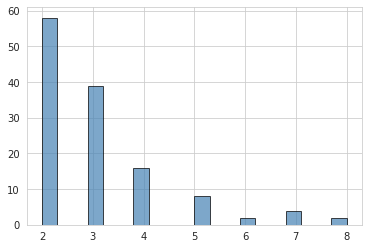

In [904]:
plt.hist(chromunity_number_per_tad, bins=20, alpha=0.7, color='steelblue', edgecolor='k')
plt.show()

### Figure 5 A,B

In [905]:
dense_GM12878 = np.loadtxt('/mnt/disk3/duanran/temp/pore_c_chr2_matrix_GM12878.txt')

/home/rduan/anaconda3/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/rduan/anaconda3/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


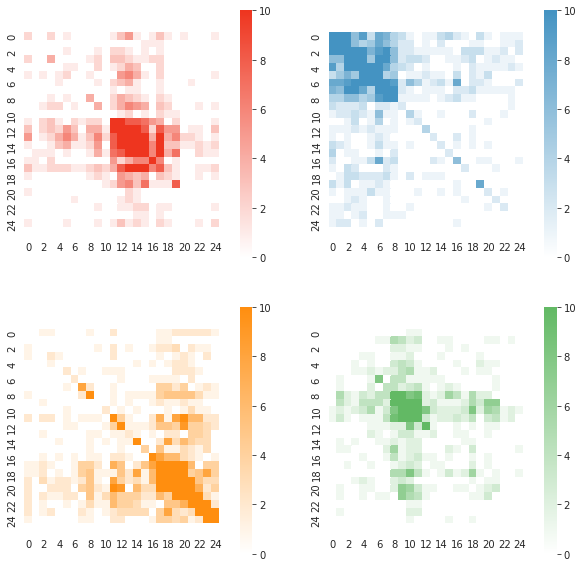

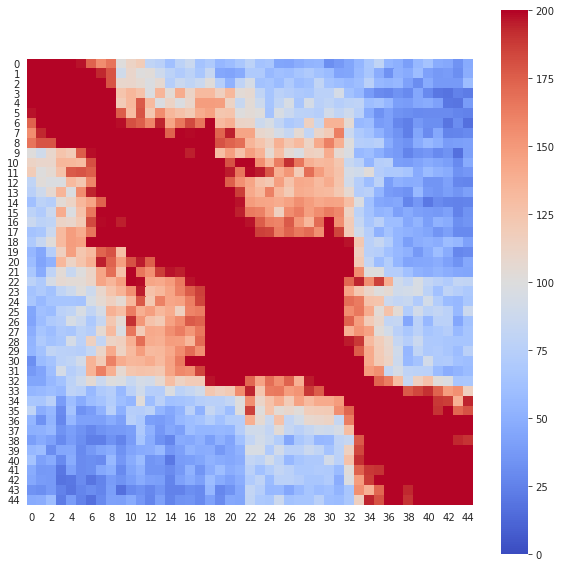

In [944]:
tad_index = 210
begin = tad_df['begin'].tolist()[tad_index]
end = tad_df['end'].tolist()[tad_index]
bin_range_begin = begin
bin_range_end = end

data_chr_unchange = reads
bin_range_read = data_chr_unchange[(data_chr_unchange['align1_start'] > bin_range_begin * resolution) & (
        data_chr_unchange['align1_start'] < bin_range_end * resolution) & (data_chr_unchange[
                                                                               'align2_start'] > bin_range_begin * resolution) & (
                                           data_chr_unchange[
                                               'align2_start'] < bin_range_end * resolution)]


bin_range_read = bin_range_read[
    bin_range_read['read_idx'].map(bin_range_read['read_idx'].value_counts()) > 1]



bin_range_read_new = bin_range_read[
    ['read_idx', 'align1_start', 'align1_end', 'align2_start', 'align2_end']]
bin_range_read_new['align1_length'] = bin_range_read_new['align1_end'] - bin_range_read_new['align1_start']
bin_range_read_new['align2_length'] = bin_range_read_new['align2_end'] - bin_range_read_new['align2_start']

bin_range_read_change = bin_range_read_new.copy()
concatemers_adj_resolution = resolution
bin_range_read_change['align1_start'] = bin_range_read_change['align1_start'] // concatemers_adj_resolution
bin_range_read_change['align2_start'] = bin_range_read_change['align2_start'] // concatemers_adj_resolution
bin_range_read_change['align1_end'] = bin_range_read_change['align1_end'] // concatemers_adj_resolution
bin_range_read_change['align2_end'] = bin_range_read_change['align2_end'] // concatemers_adj_resolution

concatemers_copy = bin_range_read_change.copy()
number = concatemers_copy[['align1_start', 'align2_start']].min(axis=1).min()
concatemers_copy['align1_start'] = concatemers_copy['align1_start'] - number
concatemers_copy['align2_start'] = concatemers_copy['align2_start'] - number

max_number = concatemers_copy[['align1_start', 'align2_start']].max(axis=1).max().max()

concatemer_list = []
read_ids = concatemers_copy['read_idx'].unique().tolist()
for read_idx in read_ids:
    data_read_idx = concatemers_copy[concatemers_copy['read_idx'] == read_idx]
    bins_set = set(data_read_idx['align1_start'].tolist() + data_read_idx['align2_start'].tolist())
    concatemer_list.append(bins_set)

jacard_list_matrix = []
for i in range(len(concatemer_list)):
    jaccard_list = []
    for j in range(len(concatemer_list)):
        if i != j:
            union = concatemer_list[i] | concatemer_list[j]
            intersection = concatemer_list[i] & concatemer_list[j]
            javale = len(intersection) / len(union)
            if javale > 0.2:
                jaccard_list.append(javale)
            else:
                jaccard_list.append(0)
        else:
            jaccard_list.append(0)
    jacard_list_matrix.append(jaccard_list)

jacard_list_matrix = np.array(jacard_list_matrix)

adj_mat = np.zeros(np.shape(jacard_list_matrix))

for i in range(len(jacard_list_matrix)):
    for j in range(i + 1, len(jacard_list_matrix)):
        first_naber = nearest_naber(jacard_list_matrix[i], 25)
        secend_naber = nearest_naber(jacard_list_matrix[j], 25)
        intersection = set(first_naber) & set(secend_naber)
        if len(intersection) > 3:
            adj_mat[i, j] = len(intersection)
            adj_mat[j, i] = len(intersection)
for i in range(len(adj_mat)):
    adj_mat[i, i] = 1


mc_copy = adj_mat.copy()
adj_G = nx.from_numpy_matrix(mc_copy)
clusters = mc.get_clusters(mc.run_mcl(mc_copy, 3))
cris = []
cluster_length_list = []
for cc in clusters:
    cluster_length_list.append(len(cc))
    if len(cc) > 20:
        cluster_read_idx = []
        for c in cc:
            cluster_read_idx.append(read_ids[c])
        cris.append(cluster_read_idx)

chromunitys = []
plt.figure(figsize=(10, 10))
white_green = LinearSegmentedColormap.from_list('white_to_red', [[1,1,1,1], [0.3843,0.7255,0.3922,1]])
white_red = LinearSegmentedColormap.from_list('white_to_orange', [[1,1,1,1], [0.9333,0.2078,0.1216,1]])
white_blue = LinearSegmentedColormap.from_list('white_to_blue', [[1,1,1,1], [0.2667,0.5765,0.7608,1]])
white_orange = LinearSegmentedColormap.from_list('white_to_green', [[1,1,1,1], [1.0,0.5569,0.0588,1]])

color_list = [white_red, white_blue, white_orange, white_green]

for i in [0,1,2,3]:
    finmat = cluster_to_heatmap(bin_range_read_new, bin_range_begin, bin_range_end, cris[i],
                                resolution)
    plt.subplot(2, 2, i+1)
    sns.heatmap(finmat, cmap=color_list[i], vmin=0, vmax=10, square=True)
    # # 保存图片，900dpi
    # plt.savefig('/mnt/disk1/duanran/mactop/mactop_fig_five/chromunitys_{0}.png'.format(i), dpi=900)
plt.show()

# 绘制cool_mat bin_range_begin bin_range_end的热图
plt.figure(figsize=(10, 10))
out_range = 10
sns.heatmap(dense_GM12878[bin_range_begin-out_range:bin_range_end+out_range, bin_range_begin-out_range:bin_range_end+out_range], cmap='coolwarm', vmin=0, vmax=200, square=True)
# plt.savefig('/mnt/disk1/duanran/mactop/mactop_fig_five/all_chromunitys.png', dpi=900)
plt.show()


### Figure 5 C

/home/rduan/anaconda3/envs/python3.6/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/rduan/anaconda3/envs/python3.6/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/rduan/anaconda3/envs/python3.6/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`.

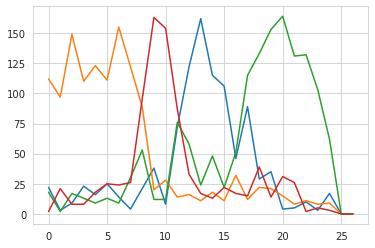

In [918]:
dense_sum = np.sum(cool_mat[bin_range_begin:bin_range_end+1, bin_range_begin:bin_range_end+1],axis=0)

for i in range(len(cris)):
    finmat = cluster_to_heatmap(bin_range_read_new, bin_range_begin, bin_range_end, cris[i],
                                resolution)

    # finmat 按列求和
    col_sum = np.sum(finmat, axis=0)
    before_nom = col_sum

    if len(before_nom) % 2 == 0:
        before_nom = np.append(before_nom, 0)

    after_nom = savgol_filter(before_nom, len(before_nom), 4)
    plt.plot(before_nom)
plt.show()

### Figure 5 E

In [983]:
def get_background_true(tad_one, tad_two, dense_mat, p_value_cutoff):
    r1 = int(pow(pow(tad_two[0] - tad_one[1], 2) + pow(tad_two[0] - tad_one[1], 2), 0.5)/2)
    r2 = int(pow(pow(tad_two[1] - tad_one[0], 2) + pow(tad_two[1] - tad_one[0], 2), 0.5)/2)
    diag_sum = 0
    diag_area = 0
    for diag in range(r1, r2+1):
        diag_sum += np.sum(np.diagonal(dense_mat, offset=diag))
        diag_area += np.size(np.diagonal(dense_mat, offset=diag))
    exp_count = diag_sum/diag_area

    count_tad_ij = np.sum(dense_mat[tad_two[0]:tad_two[1], tad_two[0]:tad_two[1]], dtype=np.int)
    count_area = (tad_two[0] - tad_one[0])*(tad_two[1] - tad_one[1])
    true_count = count_tad_ij/count_area
    count_tre = 0
    p_value = 0
    if true_count > exp_count * p_value_cutoff:
        p_value = 1
    return p_value, exp_count, true_count

def get_cliques_result_nmat(nmat, result_list,infla_value,p_value_cutoff):
    celline = 'GM12878'
    dense_mat = nmat
    mctad_result_list = result_list
    chr2 = mctad_result_list[1]
    tad_list = []
    begin = 0
    for vv in chr2:
        end = int(vv)
        tad_list.append(np.array([begin, end]))
        begin = end
    count_tru = 0
    p_value_list = []
    graph_list = []
    for tad_index_1 in range(len(tad_list)):
        for tad_index_2 in range(tad_index_1+1, len(tad_list)):
            p_value, exp_count, true_count = get_background_true(tad_list[tad_index_1],
                                                                 tad_list[tad_index_2], dense_mat,p_value_cutoff)
            if p_value == 1:
                graph_list.append(np.array([tad_index_1, tad_index_2, true_count-exp_count]))

    fin_list = graph_list

    first_list = []
    secend_list = []
    value_list = []
    for node in fin_list:
        first_list.append(int(node[0]))
        secend_list.append(int(node[1]))
        value_list.append(node[2])

    all_result = []
    all_result.append(first_list)
    all_result.append(secend_list)
    all_result.append(value_list)
    all_result = np.array(all_result)
    re = pd.DataFrame({'Source': all_result[0], 'Target': all_result[1], 'Weight':all_result[2]}, dtype=np.int64)

    # build adjacent graph
    max1 = max(re['Source'])
    max2 = max(re['Target'])
    max3 = max(max1, max2)+1

    ad_graph = np.zeros((max3, max3))
    for i, row in re.iterrows():
        ad_graph[int(row['Source']), int(row['Target'])] = row['Weight']
    ad_graph = ad_graph+ad_graph.T
    np.fill_diagonal(ad_graph, 1)
    rr = markov_cluster(ad_graph, infla_value, 1)
    np.savetxt('/mnt/disk3/duanran/mactop/tadcliqu/cliquresult.txt', rr, fmt='%d')
    co = 0
    tad_cliques_result = []
    for lin in rr:
        clists = []
        for index in range(len(lin)):
            if lin[index] > 0:
                clists.append(index)
        if len(clists) > 0:
            tad_cliques_result.append(clists)
            co += 1
    return dense_mat, tad_cliques_result, tad_list

mctad_result_list = mctad_result_format('/mnt/disk3/duanran/mactop/GM12878_result/mactop_hg38_result', 550)
hic_mat= np.loadtxt('/home/rduan/mactop_jupy/mactop_data/chr{0}-icemat-with-tad.txt'.format(2))
dense_mat, tad_cliques_result, tad_list = get_cliques_result_nmat(hic_mat, mctad_result_list, 1.7, 1.5)
cliques_list = []
for vv in tad_cliques_result:
    if len(vv) >2:
        cliques_list.append(vv)

run
lens of mctad:319
lens of mctad:320
lens of mctad:259
lens of mctad:247
lens of mctad:240
lens of mctad:222
lens of mctad:206
lens of mctad:182
lens of mctad:186
lens of mctad:177
lens of mctad:192
lens of mctad:187
lens of mctad:127
lens of mctad:120
lens of mctad:128
lens of mctad:117
lens of mctad:127
lens of mctad:114
lens of mctad:75
lens of mctad:94
lens of mctad:66
lens of mctad:64
lens of mctad:198
[11, 39, 51, 77, 115, 137, 143, 176, 189, 197, 214, 223, 236, 260, 298, 316, 329, 337, 348, 367, 398, 407, 414, 429, 449, 456, 463, 475, 487, 502, 516, 533, 554, 570, 578, 586, 603, 615, 634, 647, 655, 673, 680, 697, 710, 720, 735, 746, 766, 776, 786, 797, 817, 836, 849, 856, 873, 900, 911, 921, 938, 948, 957, 971, 991, 1010, 1030, 1040, 1069, 1079, 1096, 1114, 1124, 1151, 1154, 1175, 1185, 1199, 1213, 1223, 1238, 1271, 1280, 1300, 1313, 1327, 1362, 1370, 1380, 1387, 1396, 1407, 1420, 1431, 1454, 1466, 1473, 1485, 1499, 1514, 1533, 1541, 1548, 1559, 1581, 1600, 1629, 1647, 1654, 

In [1021]:
mactop_result_list = mctad_result_format('/mnt/disk3/duanran/mactop/GM12878_result/mactop_hg38_result', 550)
for chr_num in range(1,24):
    tad_list = get_tad_list(mactop_result_list[chr_num-1])
    unsame_data = pd.read_csv('/home/rduan/mactop_jupy/mactop_data/chr{0}_unsame_list.csv'.format(chr_num), sep=',')
    groups = unsame_data.groupby('unsame_tad_list')

    chromnuity_list = []
    all_key_list = []
    all_keys_list = []
    read_id_list = []
    for key, group in groups:
        if len(group) > 5:
            key_list = re.findall(r"\d+\.?\d*", key)
            key_list = [int(i) for i in key_list]
            un_sort_key_list = key_list
            key_list = list(set(key_list))
            if len(key_list) > 2:
                all_key_list.append(un_sort_key_list)
                all_keys_list.append(key_list)

                read_ids = np.asarray(group['unsame_loaction_reads'],dtype=np.int)
                read_id_list.append(read_ids)
    mydf = pd.DataFrame({'all_key_list': all_key_list, 'all_keys_list': all_keys_list, 'read_id_list': read_id_list})
    mydf = mydf.sort_values(by='all_keys_list', ascending=False)
    mydf = mydf[mydf['all_keys_list'].map(len) > 2]
    all_keys_list = mydf['all_keys_list'].tolist()
    all_keys_list2 = [j for i in all_keys_list for j in i]
    all_keys_list2 = list(set(all_keys_list2))
    all_keys_list2 = np.asarray(all_keys_list2)

    chrom_length = pd.read_csv('/mnt/disk3/duanran/chromsize/hg38.chrom.sizes.txt', header=None, sep='\t')
    chr_length = np.asarray(chrom_length.loc[chrom_length[0] == 'chr{0}'.format(chr_num)][1])
    chr_length = int(chr_length[0])
    mat_lenth = math.ceil(chr_length/resolution)
    genome_length_with_tad = np.zeros((mat_lenth,mat_lenth))

    begin_tad = all_keys_list2[0]
    temp_list = [begin_tad]
    all_keys_list3 = []
    for tad_index in range(1,len(all_keys_list2)):
        if all_keys_list2[tad_index] - begin_tad == 1:
            temp_list.append(all_keys_list2[tad_index])
        else:
            all_keys_list3.append(temp_list)
            temp_list = []
            temp_list.append(all_keys_list2[tad_index])
        begin_tad = all_keys_list2[tad_index]
    all_keys_list3.append(temp_list)

    for area_index in all_keys_list3:
        bb = tad_list[area_index[0]][0]
        ee = tad_list[area_index[-1]][1]
        genome_length_with_tad[bb:ee,bb:ee] = 10


    mat = np.loadtxt('/home/rduan/mactop_jupy/mactop_data/chr{0}-icemat-with-tad.txt'.format(chr_num))

    mat = np.triu(mat)
    genome_length_with_tad = np.tril(genome_length_with_tad)
    genome_length_with_tad = genome_length_with_tad + mat

    all_keys_list4 = [j for i in all_keys_list3 for j in i]
    cliques_list2 = [j for i in cliques_list for j in i]
    chromnuity_list = list(set(all_keys_list4).intersection(set(cliques_list2)))
    chromnuity_list = sorted(chromnuity_list)

    big = len([i for i in chromnuity_list if i > 120])
    small = len([i for i in chromnuity_list if i < 120])

run
lens of mctad:319
lens of mctad:320
lens of mctad:259
lens of mctad:247
lens of mctad:240
lens of mctad:222
lens of mctad:206
lens of mctad:182
lens of mctad:186
lens of mctad:177
lens of mctad:192
lens of mctad:187
lens of mctad:127
lens of mctad:120
lens of mctad:128
lens of mctad:117
lens of mctad:127
lens of mctad:114
lens of mctad:75
lens of mctad:94
lens of mctad:66
lens of mctad:64
lens of mctad:198


In [1009]:
dnase = pd.read_csv('/home/rduan/histonPeakFiles/HistonPeakFile/HG38_HistonPeakFile/hg38_Dnase.bed', header=None, sep='\t')

dnase = dnase[dnase[0] == 'chr{0}'.format(chr_num)]

dnase[1] = dnase[1]/resolution
dnase[2] = dnase[2]/resolution

dnase[1] = dnase[1].apply(np.floor)


dnase2 = dnase.groupby(1).count()

dnase2 = dnase2[[0]]
dnase2 = dnase2.reset_index()

dnase2.columns = ['index', 'count']

dnase2['index'] = dnase2['index'].astype(int)


tad_list,chromnuity_list
dnase_count = 0
bin_length = 0
for tad_index in chromnuity_list:
    bb = tad_list[tad_index-1][0]
    ee = tad_list[tad_index-1][1]
    tad_length = ee-bb
    bin_length += tad_length
    dnase3 = dnase2[(dnase2['index'] >= bb) & (dnase2['index'] < ee)]
    dnase3 = dnase3['count'].tolist()
    dnase_count += sum(dnase3)

In [1010]:
# dnase2 count列求和
dnase_count = dnase2['count'].sum()
dnase_count/tad_list[-1][1]

0.6608478802992519

In [1011]:
random_dnase_value = []
for index in range(1000):
    random_list = random.sample(range(1,tad_list[-1][1]), 1000)
    random_count = 0
    # 取出dnase2中index列为random_list的行并计算count列的和
    random_count = dnase2[dnase2['index'].isin(random_list)]['count'].sum()
    random_dnase_value.append(random_count/1000)

In [1014]:
# 以chromnuity_list为索引取出tad_list中的元素
tad_list2 = [tad_list[i-1] for i in chromnuity_list]
# tad_list2中每个元素范围包括的元素
tad_list3 = [list(range(i[0],i[1])) for i in tad_list2]
tad_list4 = [j for i in tad_list3 for j in i]

random_dnase_value2 = []
for index in range(1000):
    # 从tad_list4中随机抽取1000个数字组成一个list
    random_list = random.sample(tad_list4, 300)
    random_count = 0
    # 取出dnase2中index列为random_list的行并计算count列的和
    random_count = dnase2[dnase2['index'].isin(random_list)]['count'].sum()
    random_dnase_value2.append(random_count/300)

/home/rduan/anaconda3/envs/python3.6/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/rduan/anaconda3/envs/python3.6/lib/python3.6/site-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


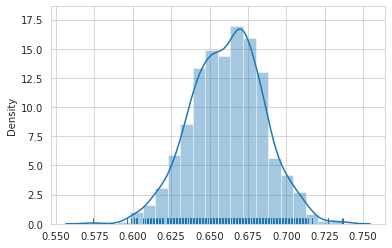

In [1015]:
sns.distplot(random_dnase_value, bins=20, kde=True, rug=True)
plt.show()


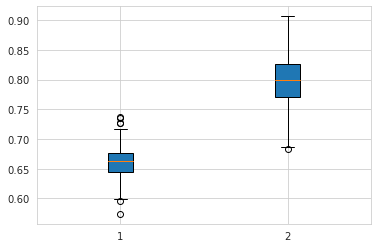

In [1016]:
plt.boxplot([random_dnase_value, random_dnase_value2], vert=True, whis=1.5, patch_artist=True, meanline=False, showbox=True, showcaps=True, showfliers=True, notch=False)
plt.show()

### Figure 5 F

In [1017]:
# hg38_Dnase.bed             hg38_GM12878_H3K4me3.bed
# hg38_GM12878_H3K27ac.bed   hg38_GM12878_H3K79me2.bed
# hg38_GM12878_H3K27me3.bed  hg38_GM12878_H3K9ac.bed
# hg38_GM12878_H3K36me3.bed  hg38_GM12878_H3K9me3.bed
# hg38_GM12878_H3K4me1.bed   hg38_GM12878_H4K20me1.bed
histon_name_list = ['H3K4me3', 'H3K27ac', 'H3K79me2', 'H3K27me3', 'H3K9ac', 'H3K36me3', 'H3K9me3', 'H3K4me1', 'H4K20me1']
histon_lists =[]
genome_length_with_bin = tad_list[-1][1]
# 将histon_name_list中的元素进行同样的操作
for histon_name in histon_name_list:
    histon = pd.read_csv('/home/rduan/histonPeakFiles/HistonPeakFile/HG38_HistonPeakFile/hg38_GM12878_{0}.bed'.format(histon_name), sep='\t', header=None)
    histon[1] = histon[1]//resolution
    histon[2] = histon[2]//resolution
    histon = histon[histon[0] == 'chr{0}'.format(chr_num)]
    histon = histon.sort_values(by=1, ascending=True)
    histon_list = histon[1].tolist()
    histon_lists.append(histon_list)
    print(histon_name)

H3K4me3
H3K27ac
H3K79me2
H3K27me3
H3K9ac
H3K36me3
H3K9me3
H3K4me1
H4K20me1


In [1018]:
chromnuity_bin = tad_list4
unchromnuity_bin = [i for i in range(1,genome_length_with_bin) if i not in chromnuity_bin]
clen = len(chromnuity_bin)
ulen = len(unchromnuity_bin)
clen,ulen

(409, 1195)

In [1019]:
cout_list = []
ucout_list = []
for index in range(len(histon_lists)):
    h3 = histon_lists[index]
    #统计h3中重复的元素和元素个数
    h3_dict = {}
    for i in h3:
        if i in h3_dict:
            h3_dict[i] += 1
        else:
            h3_dict[i] = 1

    cout = 0
    h3_dict.keys()
    for cbin in chromnuity_bin:
        if cbin in h3_dict.keys():
            cout += h3_dict[cbin]

    ucout = 0
    h3_dict.keys()
    for cbin in unchromnuity_bin:
        if cbin in h3_dict.keys():
            ucout += h3_dict[cbin]

    print(cout/clen, ucout/ulen)
    cout_list.append(cout/clen)
    ucout_list.append(ucout/ulen)


0.687041564792176 0.6443514644351465
0.8899755501222494 0.7205020920502092
1.6356968215158925 1.2083682008368202
0.49144254278728605 0.32468619246861924
0.4180929095354523 0.42594142259414225
1.4645476772616137 1.2267782426778242
0.3594132029339853 0.2669456066945607
1.3471882640586796 1.0694560669456068
0.06845965770171149 0.03933054393305439


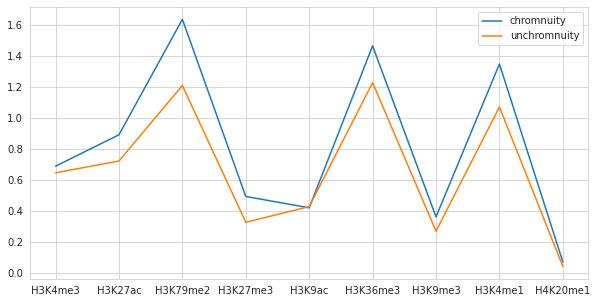

In [1020]:
# 画图
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
plt.plot(histon_name_list, cout_list, label='chromnuity')
plt.plot(histon_name_list, ucout_list, label='unchromnuity')
plt.legend()
plt.show()

In [1074]:
sub_cout_list = [0.7101001780688744, 0.7772717201118582, 1.4961473891346382, 0.37966881290006815, 0.4863791173687629, 1.5162113993974347, 0.27655097925248523, 1.2401417003677258, 0.11608534737050658]
sub_count2_list = [0.7226243880635028, 0.7362148237945996, 1.414963323798801, 0.34746423869552934, 0.47473022173549034, 1.3988545073341976, 0.26372470521671576, 1.1544770404707987, 0.09296400770489295]

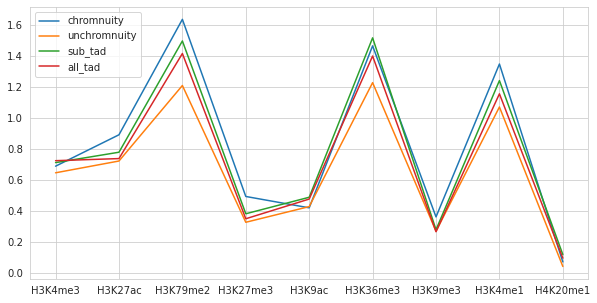

In [1075]:
plt.figure(figsize=(10,5))
plt.plot(histon_name_list, cout_list, label='chromnuity')
plt.plot(histon_name_list, ucout_list, label='unchromnuity')
plt.plot(histon_name_list, sub_cout_list, label='sub_tad')
plt.plot(histon_name_list, sub_count2_list, label='all_tad')
plt.legend()
plt.show()

In [1079]:
kb5_chrom_bin_list = []
for biis in chromnuity_bin:
    for numbers in range(biis*10,(biis+1)*10):
        kb5_chrom_bin_list.append(numbers)

In [1080]:
kb5_tad_bin_list = []
for biis in unchromnuity_bin:
    for numbers in range(biis*10,(biis+1)*10):
        kb5_tad_bin_list.append(numbers)

In [1088]:
histon_name_list =[ 'H3K4me1','H3K4me2','H3K4me3','H3K9ac', 'H3K36me3']
histon_lists =[]
chr_num = 2
# 将histon_name_list中的元素进行同样的操作
for histon_name in histon_name_list:
    histon = pd.read_csv('/home/rduan/histonPeakFiles/HistonPeakFile/HG38_HistonPeakFile/hg38_GM12878_{0}.bed'.format(histon_name), sep='\t', header=None)
    histon[1] = histon[1]//5000
    histon[2] = histon[2]//5000
    histon = histon[histon[0] == 'chr{0}'.format(chr_num)]
    histon = histon.sort_values(by=1, ascending=True)
    histon_list = histon[1].tolist()
    histon_lists.append(histon_list)
    print(histon_name)

H3K4me1
H3K4me2
H3K4me3
H3K9ac
H3K36me3


In [1089]:
cout_list = []
ucout_list = []
for index in range(len(histon_lists)):
    h3 = histon_lists[index]
    #统计h3中重复的元素和元素个数
    h3_dict = {}
    for i in h3:
        if i in h3_dict:
            h3_dict[i] += 1
        else:
            h3_dict[i] = 1

    cout = 0
    h3_dict.keys()
    for cbin in kb5_chrom_bin_list:
        if cbin in h3_dict.keys():
            cout += h3_dict[cbin]

    ucout = 0
    h3_dict.keys()
    for cbin in kb5_tad_bin_list:
        if cbin in h3_dict.keys():
            ucout += h3_dict[cbin]

    print(ucout/ulen,cout/clen)
    cout_list.append(cout/clen)
    ucout_list.append(ucout/ulen)

1.9163179916317992 1.36919315403423
1.9020920502092051 1.3887530562347188
1.1464435146443515 0.7799511002444988
0.7682008368200837 0.43765281173594134
2.2535564853556487 1.4327628361858191


ValueError: The number of FixedLocator locations (9), usually from a call to set_ticks, does not match the number of ticklabels (5).

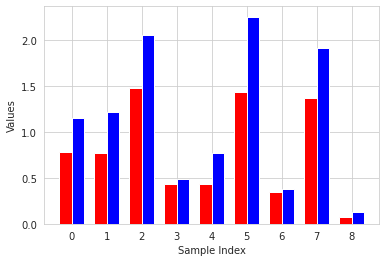

In [1090]:
# 数据
data1 = [0.7799511002444988, 0.7701711491442543, 1.4743276283618583, 0.43031784841075793, 0.43765281173594134,
         1.4327628361858191, 0.3471882640586797, 1.36919315403423, 0.07579462102689487]
data2 = [1.1464435146443515, 1.2167364016736402, 2.0594142259414228, 0.4928870292887029, 0.7682008368200837,
         2.2535564853556487, 0.37656903765690375, 1.9163179916317992, 0.12468619246861924]

# 定义X轴位置
x = np.arange(len(data1))  # [0, 1, 2, ..., len(data1)-1]
width = 0.35  # 柱子的宽度

# 创建图形
fig, ax = plt.subplots()

# 绘制柱状图
rects1 = ax.bar(x - width/2, data1, width, color='red', label='TAD')
rects2 = ax.bar(x + width/2, data2, width, color='blue', label='chromunity')

# 添加一些标签和标题
ax.set_xlabel('Sample Index')
ax.set_ylabel('Values')
ax.set_xticks(x)
ax.set_xticklabels(histon_name_list)
plt.xticks(rotation=45)
ax.legend()

# 显示图形
plt.show()